In [1]:
from __future__ import division
%matplotlib nbagg
import pandas as pd
import os, sys
import numpy as np
from collections import defaultdict
from caseDetection import detect_case
from world_map_maker import create_world_map
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}
matplotlib.rc('font', **font)
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
#import matplotlib as mpl
#mpl.use("GTK3cairo")
#import matplotlib.pyplot as plt
#plt.plot([1,2,3,4],'*-')

In [2]:
SAMPLENAME = 'Snapshot3'
RESULTS = "results/" + SAMPLENAME + "/"
if not os.path.exists(RESULTS):
    os.makedirs(RESULTS)

In [4]:
df_all = pd.read_pickle("data_Apr20/case_detected_all_Apr20.pkl").reset_index()
df_sIP_subcat = pd.read_csv("data/Servers_IMC.txt")

In [38]:
df_DNS = pd.read_csv("data/overall-censorship-analysis-stripped.data")
df_DNS = df_DNS[['ips', 'domain', 'isDNSBlock']].rename(columns={'ips':'sIP'})
df_DNS_filtered = ( df_DNS [ df_DNS['sIP'].isin( df_sIP_subcat.sIP ) ] ).drop_duplicates()

In [14]:
df_all.head(1)

,index,ipids,ts,diff_list,retransmit_times,gIP,sIP,port,k1,k2,country,first_ts,diff_p1,diff_p2,domain,subcat,case,intervention,pvalue
0,52000,"[50767, 50770, 50773, 50774, 50775, 50779, 507...","[60, 62, 64, 68, 76, 92]","[1, 2, 2, 0, 0, 3, 3, 1, 2, 5, 4, 4, 0, 1, 1, ...","[0, 2, 4, 8, 16, 32]",61.6.2.62,50.17.211.188,80,10,40,MY,60,60,60,myfitnesspal.com,health,2,20.4,6.776888e-48


In [29]:
df_sIP_subcat.head()

,sIP,domain,subcat
0,23.235.33.64,deadspin.com,sports
1,216.239.38.21,uproxy.org,circum
2,41.185.22.146,medihelp.co.za,world
3,184.73.236.82,history.com,kids_and_teens|arts|business
4,23.212.53.230,navbharattimes.indiatimes.com,news|world


In [248]:
print len( df_sIP_subcat['sIP'].unique() )
print len( df_DNS_filtered['sIP'].unique() )

580
476


In [67]:
df_DNS_filtered.to_csv(RESULTS + "DNS_blocking_unique.csv")
df_DNS_missing_sIP = df_sIP_subcat[ ~ df_sIP_subcat['sIP'].isin( df_DNS_filtered['sIP'] ) ] 
df_DNS_missing_sIP.to_csv(RESULTS + "DNS_Servers_IMC_final_missing_sIP.csv")
df_DNS_missing_sIP.head()

,sIP,domain,subcat
0,23.235.33.64,deadspin.com,sports
4,23.212.53.230,navbharattimes.indiatimes.com,news|world
11,184.29.106.57,cbc.ca,news|arts|regional|health|sports
15,23.235.44.129,gizmodo.com,home
26,108.174.10.10,www.linkedin.com,world|computers


# Sanitize and Unbiasing
- see how many are case 0 and 4
- select best case for those with multiple case entries per sIP

In [11]:
# lengths of case good and case bad
df_good = df_all [  df_all['case'].isin([1,2,3]) ]
df_bad = df_all [  df_all['case'].isin([-1,0,4]) ]
print len(df_bad) / len(df_good)
print len(df_all)

0.108782614375
135817


In [12]:
# threshold number of sIPs unique tested per country
THRESHOLD = 400

# per country, how many unique sIPs
df_unique_sIP_per_country = df_all.groupby(['country'])['sIP'].unique().apply(lambda x:len(x))
df_current = df_unique_sIP_per_country[df_unique_sIP_per_country > THRESHOLD]
valid_countries = df_current.index
TOTAL_NUM_VALID_COUNTRIES = len(valid_countries)

print valid_countries, TOTAL_NUM_VALID_COUNTRIES

# filter df_good to only valid countries
# remove extra columns
df_valid = df_good[  df_good['country'].isin(valid_countries)   ] [['sIP', 'gIP', 'country',
                                                                    'domain', 'subcat', 'case']]

Index([u'AE', u'AF', u'AL', u'AM', u'AO', u'AR', u'AT', u'AU', u'AZ', u'BA', u'BD', u'BE', u'BF', u'BG', u'BH', u'BI', u'BJ', u'BO', u'BW', u'BY', u'CA', u'CD', u'CG', u'CH', u'CI', u'CL', u'CM', u'CN', u'CO', u'CR', u'CU', u'CZ', u'DE', u'DK', u'DO', u'DZ', u'EC', u'EE', u'EG', u'ES', u'FI', u'FR', u'GA', u'GB', u'GE', u'GH', u'GM', u'GQ', u'GR', u'GT', u'HK', u'HN', u'HR', u'HT', u'HU', u'ID', u'IE', u'IL', u'IN', u'IQ', u'IR', u'IT', u'JM', u'JO', u'JP', u'KE', u'KG', u'KH', u'KR', u'KZ', u'LA', u'LK', u'LR', u'LS', u'LT', u'LV', u'LY', u'MA', u'MD', u'MG', u'MK', u'ML', u'MM', u'MR', u'MU', u'MW', u'MX', u'MY', u'MZ', u'NA', u'NE', u'NG', u'NI', u'NL', u'NO', u'NP', u'NZ', u'OM', u'PA', u'PE', ...], dtype='object') 142


In [68]:
gp_good_sIP_country = df_valid.groupby(['sIP', 'country'])

# even though there are multiple cases per sIP, country pair
# select only one
df_per_sIP_country = gp_good_sIP_country['case'].unique().reset_index()
df_per_sIP_country['count'] = gp_good_sIP_country['case'].count().reset_index()['case']
df_per_sIP_country['unique_count'] = df_per_sIP_country['case'].apply(lambda x: len(x))

In [69]:
df_temp = df_per_sIP_country[df_per_sIP_country['unique_count'] > 1]
df_temp['case'].head()

55     [3, 2]
73     [2, 3]
78     [3, 2]
136    [2, 1]
137    [2, 1]
Name: case, dtype: object

In [70]:
print "sIP, country with discrepancy: ", len( df_per_sIP_country[df_per_sIP_country['unique_count'] > 1] ) / len (df_per_sIP_country)

sIP, gIP, country with discrepancy:  0.0506393861893


#### choose first valid index of each sip,country pair

In [71]:
def choose_valid_case(case_list):
    """ return first case that was either 1, 2, 3"""
    for x in case_list:
        if (x == 1) or (x == 2) or (x == 3):
            return x
    return case_list[0]

In [79]:
df_unique = gp_good_sIP_country['case'].apply(choose_valid_case).reset_index()
# drop duplicate rows with same sIP, country, case
df_unique = df_unique.drop_duplicates()
print len( df_unique.sIP.unique() )
print len( df_unique.country.unique() )
print len( df_unique )

506
142
64515


In [76]:
# Quick check
df_temp = df_unique.groupby(['sIP', 'country'])['case'].unique().reset_index()
df_temp['count'] = df_unique.groupby(['sIP', 'country'])['case'].count().reset_index()['case']
df_temp['unique_count'] = df_per_sIP_country['case'].apply(lambda x: len(x))
df_temp[df_temp['count']>1]

,sIP,country,case,count,unique_count


In [81]:
df_unbiased = df_unique.merge(df_sIP_subcat, on=['sIP'])
df_unbiased.subcat.unique()

array(['circum', 'world|recreation', 'vpn', 'society', 'health',
       'kids_and_teens|games', 'adult', 'sports', 'computers', 'science',
       'arts', 'world|computers', 'world|adult', 'regional|shopping',
       'news|regional', 'reference', 'regional|shopping|reference',
       'computers|reference', 'world|reference', 'science|regional|health',
       'kids_and_teens|arts|games', 'recreation',
       'regional|health|reference', 'science|health', 'computers|business',
       'kids_and_teens|regional|science',
       'world|regional|shopping|business', 'recreation|business',
       'society|regional|health', 'science|regional', 'science|computers',
       'games', 'business', 'world', 'regional|games', 'home',
       'world|regional|computers', 'home|business',
       'world|regional|business', 'regional|business',
       'science|kids_and_teens|arts|health|news', 'kids_and_teens|arts',
       'home|arts|business|news', 'society|health', 'society|world',
       'arts|recreation', 

# WORLD MAP BY COUNTRY
### ignore subcat

In [281]:
df_censorship = df_unbiased.groupby(['country', 'case'])['sIP'].count().reset_index().rename(columns={'sIP':'count'}).pivot(index='country', columns='case', values='count')
df_censorship = df_censorship.rename( columns= {k:str(k) for k in df_censorship.columns} )
df_censorship['total'] = df_censorship.sum(axis=1)
df_censorship['case1'] = df_censorship['1']/df_censorship['total'] 
df_censorship['case3'] = df_censorship['3']/df_censorship['total'] 
df_censorship['case2'] = df_censorship['2']/df_censorship['total']
df_censorship['case13'] = (df_censorship['1']+df_censorship['3'])/df_censorship['total']

censorship_ratio = defaultdict(int)
censorship_ratio['case1'] = df_censorship['case1'].to_dict()
censorship_ratio['case2'] = df_censorship['case2'].to_dict()
censorship_ratio['case3'] = df_censorship['case3'].to_dict()
censorship_ratio['case13'] = df_censorship['case13'].to_dict()


df_censorship.sort('case2', inplace=True)
df_censorship.to_html(RESULTS+ 'country_wise_censorship_total-filtered400.htm')
df_censorship.head(10)

case,1,2,3,total,case1,case3,case2,case13
country,,,,,,,,
LR,15,108,291,414,0.036232,0.702899,0.260870,0.739130
PG,180,181,31,392,0.459184,0.079082,0.461735,0.538265
TM,115,230,39,384,0.299479,0.101562,0.598958,0.401042
AL,81,235,29,345,0.234783,0.084058,0.681159,0.318841
CU,8,350,124,482,0.016598,0.257261,0.726141,0.273859
MD,29,303,82,414,0.070048,0.198068,0.731884,0.268116
US,43,299,63,405,0.106173,0.155556,0.738272,0.261728
CG,59,335,51,445,0.132584,0.114607,0.752809,0.247191
JO,4,373,110,487,0.008214,0.225873,0.765914,0.234086


In [282]:
bins = [0, 0.1]
create_world_map(censorship_ratio['case1'], "Server to Client Dropped", True, bins)

0.00608519269777 0.459183673469
http://chart.apis.google.com/chart?cht=map:fixed=-60,-20,80,-35&chs=600x400&chma=0,60,0,0&chld=AA|AA|AA|AA|AA|AA|PS|OM|GM|JO|PH|ML|LK|LA|BH|GA|MG|CD|NE|CM|DZ|CI|GR|IQ|LS|BY|BW|BA|LT|GH|MU|SZ|MW|PA|MM|NA|MY|SO|TG|BI|KE|CU|BG|LY|EG|MR|HT|EC|CR|SI|MK|SE|TT|BD|EE|BF|SL|SA|UZ|UG|NO|FR|SV|ZM|CL|PK|TZ|DK|DO|SK|GT|PE|TW|MZ|TL|ZW|NP|SD|RS|KH|NG|JP|SN|SY|NI|MA|PL|UY|KG|AR|CZ|RO|PY|CO|KR|GQ|ID|IR|UA|LR|IT|HU|LV|AM|NZ|SG|IN|MX|AO|ES|HR|GB|NL|PT|AT|DE|VN|HN|RU|VE|BE|BO|AU|FI|TH|IE|CA|CH|BJ|HK|MD|JM|AF|KZ|TR|ZA|AZ|AE|CN|TN|IL|GE|US|RW|CG|AL|TM|PG&chco=808080|808080|c6dbef|9ecae1|6baed6|3182bd|08519c|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|9ecae1|9eca

In [283]:
bins = [0, 0.2]
create_world_map(censorship_ratio['case3'], "Client to Server Dropped", True, bins)

0.0790816326531 0.702898550725
http://chart.apis.google.com/chart?cht=map:fixed=-60,-20,80,-35&chs=600x400&chma=0,60,0,0&chld=AA|AA|AA|AA|AA|AA|PG|AL|VN|AZ|TM|RW|PA|AU|GA|CH|TG|TL|TT|TN|IL|TZ|GE|AR|CG|KH|MM|ZA|VE|TH|GT|JP|HR|GQ|CD|HT|BW|DK|CA|PE|BI|SG|PY|PH|SD|AE|PT|EE|LK|JM|CI|NE|SO|TW|HN|SL|GB|AM|AF|AT|HK|ZM|UG|NA|DO|IN|EG|OM|MA|GH|SV|NI|CM|DE|BA|BD|AO|EC|BJ|FR|RO|MG|KE|IQ|CZ|CR|KR|MR|KZ|CO|PK|LS|DZ|MZ|SY|GM|CL|ES|LV|MU|ML|BH|IT|PS|UA|MX|SI|NZ|FI|SZ|LA|BG|LY|CN|SA|GR|MW|ID|SN|KG|NG|BY|NL|BO|BF|MY|TR|RU|NO|HU|IE|US|ZW|LT|NP|UZ|SK|RS|BE|IR|UY|PL|MK|SE|MD|JO|CU|LR&chco=808080|808080|c6dbef|9ecae1|6baed6|3182bd|08519c|9ecae1|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|3182bd|3182bd|3182bd|3182bd|3182bd|3182bd|3182bd|3182bd|3182bd|3182bd|3182bd|3182bd|3182bd|3182bd|3182bd|3182bd|3182bd|3182b

In [284]:
bins = [0, 0.25]
create_world_map(censorship_ratio['case13'], "TCP/IP Censorship", True, bins)

0.117408906883 0.739130434783
http://chart.apis.google.com/chart?cht=map:fixed=-60,-20,80,-35&chs=600x400&chma=0,60,0,0&chld=AA|AA|AA|AA|AA|AA|GA|PA|TG|TT|CD|PH|LK|BW|MM|OM|CI|NE|TL|TZ|HT|BI|CM|GH|MG|SO|IQ|BA|PS|EE|NA|GT|GM|DK|ML|EG|DZ|KH|PE|SL|BH|LS|JP|AR|KE|EC|UG|ZM|MU|LA|SD|BD|SV|CR|MR|TW|DO|FR|GR|SZ|VN|GQ|PY|NI|SI|MA|PK|BG|LY|CL|MW|MZ|BY|SA|SY|CZ|RO|SG|MY|KR|AM|HR|CO|AU|BF|IN|SN|LT|PT|UA|NG|IT|NO|VE|AO|GB|LV|AT|KG|CH|HN|ID|NZ|DE|MX|TH|ES|ZW|UZ|NP|CA|SK|AZ|RS|HU|HK|JM|NL|BJ|FI|ZA|AF|MK|BO|RU|SE|KZ|IR|TN|AE|PL|UY|IL|GE|IE|RW|BE|TR|CN|JO|CG|US|MD|CU|AL|TM|PG|LR&chco=808080|808080|c6dbef|9ecae1|6baed6|3182bd|08519c|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|6baed6|3182bd

### Grouping by case2 vs case1/case3

<IPython.core.display.Javascript object>


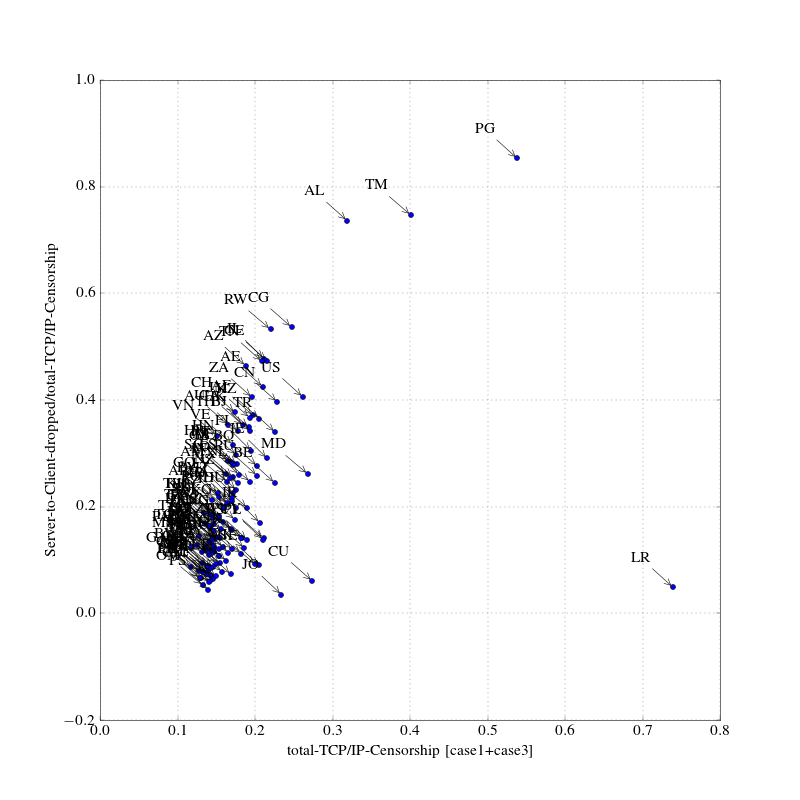

In [286]:
df_censorship['case1/case13'] = df_censorship['case1']/(df_censorship['case3']+df_censorship['case1'])

fig2, ax2 = plt.subplots(1,1, figsize=(10,10))
ax2.scatter(df_censorship['case13'], df_censorship['case1/case13'])
for label, x, y in zip(df_censorship.index, df_censorship['case13'], df_censorship['case1/case13']):
    ax2.annotate(
        label, 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
#        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
#ax2.set_yscale('log')
ax2.set_ylabel('Server-to-Client-dropped/total-TCP/IP-Censorship')
ax2.set_xlabel('total-TCP/IP-Censorship [case1+case3]')
ax2.grid(1)
fig2.savefig('censorship_grouped_by_country')
fig2.show()

<IPython.core.display.Javascript object>


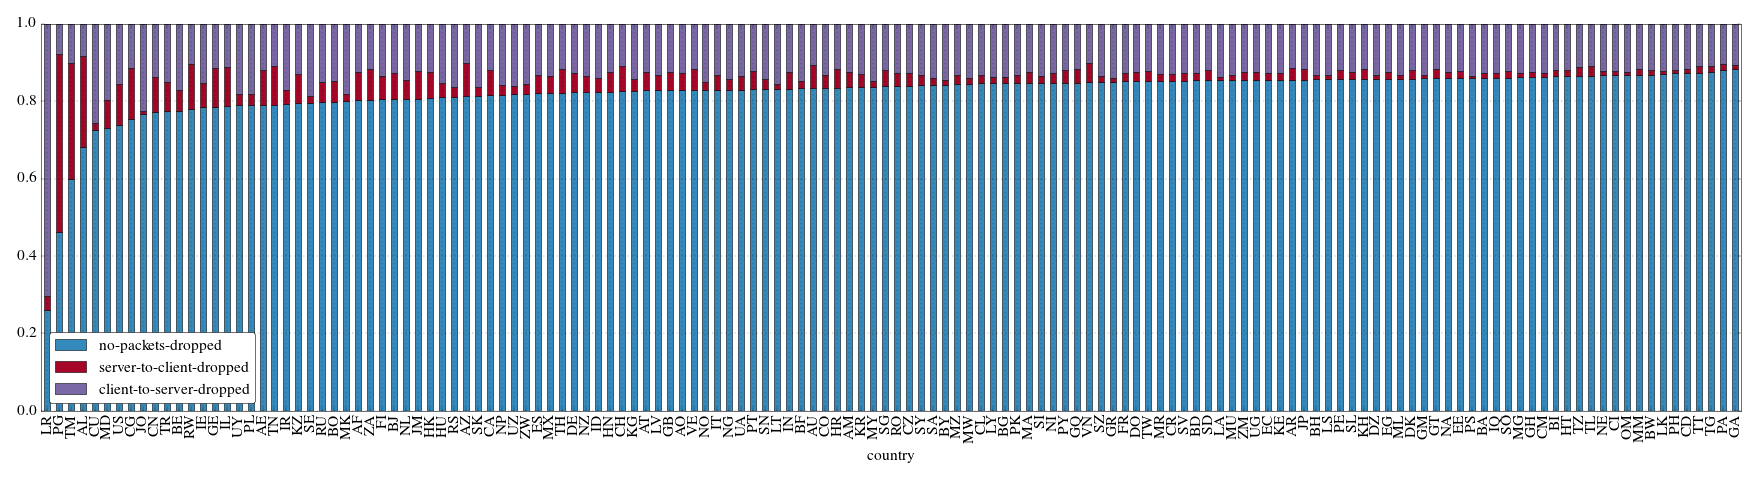

In [290]:
fig1, ax1 = plt.subplots(1,1, figsize=(22,6))
#df = df_censorship[['case2', 'case1', 'case3', 'case04']].rename(columns = {'case2':'uncensored',
#                                                                  'case1':'server2client',
#                                                                  'case3':'client2server',
#                                                                   'case04': 'unknown'})
df = df_censorship[['case2', 'case1', 'case3']].rename(columns = {'case2':'no-packets-dropped',
                                                                  'case1':'server-to-client-dropped',
                                                                  'case3':'client-to-server-dropped'})
df.plot(kind='bar', stacked=True, ax=ax1)
ax1.legend(loc='best', prop={'size':14})
fig1.tight_layout()
fig1.savefig(RESULTS + "cases_ratio_by_country_stacked_bar")

# COUNTRY, SUBCAT
- if one sIP has many subcats => duplicate entries

In [5]:
subcat_duplicated = defaultdict(list)
for ix, row in df_sIP_subcat.iterrows():
    for subcat in row[2].split("|"):
        subcat_duplicated['sIP'].append(row[0])
        subcat_duplicated['domain'].append(row[1])
        subcat_duplicated['subcat'].append(subcat)
df_sIP_subcat_disjoint = pd.DataFrame(subcat_duplicated)
df_sIP_subcat_disjoint.to_csv("data/Servers_IMC_disjoint.txt")

In [8]:
df_sIP_subcat_disjoint.groupby('subcat').count()

,domain,sIP
subcat,,
adult,43,43
alexa-top-sites-circum.txt,1,1
arts,52,52
business,55,55
circum,28,28
computers,55,55
games,37,37
health,42,42
home,40,40


In [9]:
# disjoint duplicate entries
df_disjoint = df_unbiased[['sIP', 'country', 'case']].merge(df_sIP_subcat_disjoint, on=['sIP'])

NameError: name 'df_unbiased' is not defined

In [137]:
grouped_by_country_subcat_case = df_disjoint.groupby(['country', 'subcat', 'case'])
df_count_per_country_subcat_case = grouped_by_country_subcat_case.count().rename(columns={'sIP':'count'})[['count']]
df_count_per_country_subcat_case.head(10)

count
country subcat   case       
AE      adult    1         3
                 2        24
                 3         3
        arts     1         3
                 2        35
                 3         2
        business 1         4
                 2        25
                 3         6
        circum   1         1

## create df_case_count by unstacking cases from previous dataframe separately

In [251]:
# replace nan with 0
df_case_count = df_count_per_country_subcat_case.unstack(level=-1)['count'].fillna(0)
df_case_count['total'] = df_case_count.sum(axis=1)
df_case_count.to_html(RESULTS+'cases_per_country_subcat-unbiased-CenP.htm')
df_case_count.head()

case               1   2  3  total
country subcat                    
AE      adult      3  24  3     30
        arts       3  35  2     40
        business   4  25  6     35
        circum     1  13  1     15
        computers  2  26  8     36

In [291]:
group_by_subcat = df_case_count.reset_index().groupby('subcat')

### Per Subcategory Analysis, including errors

In [299]:
def get_ratios(subcat, indices, df_case_count):
    #if subcat == 'all':
        
    temp_df = df_case_count.ix[ group_by_subcat.groups[subcat] ].reset_index()
    temp_df['censored'] = temp_df[1]+temp_df[3]
    
    #temp_df['unknown'] = temp_df[0]+temp_df[4]
    #temp_df = temp_df.rename(columns={2:'uncensored'})[['country', 'censored', 'uncensored', 'unknown']].set_index('country')
    temp_df = temp_df.rename(columns={2:'uncensored'})[['country', 'censored', 'uncensored', 1, 3]].set_index('country')

    # calculate ratios
    temp_df['total'] = temp_df.sum(axis=1)
    temp_df['ratio-case1'] = temp_df[1]/temp_df['total']
    temp_df['ratio-case3'] = temp_df[3]/temp_df['total']
    temp_df['ratio-censored'] = temp_df['censored']/(temp_df['total'])
    temp_df['ratio-uncensored'] = temp_df['uncensored']/(temp_df['total'])
    #temp_df['ratio-unknown'] = temp_df['unknown']/(temp_df['total'])

    # replace no entries with 0
    df_country_case = temp_df.fillna(0)
    return df_country_case

In [300]:
country_case_per_subcat = defaultdict(int)

# iterate over groupby object, indices
for subcat, indices in group_by_subcat.groups.iteritems():
    country_case_per_subcat[subcat] = get_ratios(subcat, indices, df_case_count)
    print subcat, len(country_case_per_subcat[subcat])
    
df_country_case_subcat = pd.concat(country_case_per_subcat)

science 142
arts 142
regional 142
shopping 142
reference 142
business 142
world 142
kids_and_teens 142
computers 142
recreation 142
sports 142
society 142
games 142
adult 142
home 142
health 142
news 142
vpn 142
circum 142


## Data description
- total experiments: means, var per country
- total experiments: means, var per subcat

In [301]:
# save list of countries
pd.Series(df_country_case_subcat.reset_index()['country'].unique()).to_csv(RESULTS+"list_of_countries.csv")

In [302]:
df_experiment_stats = df_country_case_subcat['total'].unstack()
per_country = df_experiment_stats.describe().T[['count','mean','std','min','max']].rename(
    columns={'count':'num_countries', 'mean':'avg_num_measurements_per_subcat'})
per_country.to_html(RESULTS + "experiment_total_stats_per_country.html")
per_subcat = df_experiment_stats.T.describe().T[['count','mean','std','min','max']].rename(
    columns={'count':'num_subcats', 'mean':'avg_num_measurements_per_country'})
per_subcat.to_html(RESULTS + "experiment_total_stats_per_subcat.html")

## CENSORSHIP RATIOS

In [303]:
all_results = list(df_country_case_subcat.columns)
print all_results

['censored', 'uncensored', 1L, 3L, 'total', 'ratio-case1', 'ratio-case3', 'ratio-censored', 'ratio-uncensored']


In [304]:
censorship_ratio = defaultdict(int)
for key in ['ratio-case1', 'ratio-case3', 'ratio-censored', 'ratio-uncensored', 'total']:
    censorship_ratio[key] = df_country_case_subcat[key].unstack(0)
    censorship_ratio[key].to_html(RESULTS + 'ALL_Apr20_censorship_'+key+'.html')

In [161]:
censorship_ratio['ratio-censored']

,adult,arts,business,circum,computers,games,health,home,kids_and_teens,news,recreation,reference,regional,science,shopping,society,sports,vpn,world
country,,,,,,,,,,,,,,,,,,,
AE,0.166667,0.111111,0.222222,0.117647,0.217391,0.200000,0.147059,0.189189,0.142857,0.133333,0.250000,0.088235,0.180328,0.155556,0.148148,0.210526,0.000000,0.187500,0.203125
AF,0.181818,0.150943,0.215385,0.130435,0.209677,0.243902,0.173913,0.131579,0.142857,0.128205,0.219512,0.127660,0.150538,0.117647,0.125000,0.195652,0.103448,0.166667,0.133333
AL,0.250000,0.186047,0.220000,0.062500,0.311111,0.361111,0.178571,0.342105,0.277778,0.236842,0.343750,0.236842,0.190476,0.210526,0.258065,0.275000,0.200000,0.272727,0.192308
AM,0.121212,0.090909,0.169811,0.000000,0.170213,0.205882,0.153846,0.138889,0.058824,0.111111,0.228571,0.076923,0.126582,0.133333,0.093750,0.189189,0.041667,0.187500,0.098361
AO,0.142857,0.083333,0.190476,0.130435,0.186441,0.200000,0.217391,0.117647,0.078947,0.081081,0.157895,0.108696,0.105882,0.134615,0.105263,0.222222,0.000000,0.133333,0.125000
AR,0.078947,0.108696,0.169811,0.050000,0.160000,0.194444,0.146341,0.090909,0.054054,0.058824,0.200000,0.111111,0.089744,0.044444,0.090909,0.179487,0.038462,0.176471,0.095238
AT,0.162162,0.068182,0.102041,0.095238,0.173077,0.235294,0.175000,0.114286,0.054054,0.062500,0.184211,0.146341,0.118421,0.111111,0.117647,0.200000,0.038462,0.222222,0.144928
AU,0.216216,0.025000,0.156863,0.095238,0.108696,0.153846,0.179487,0.137931,0.031250,0.083333,0.176471,0.027778,0.094595,0.133333,0.111111,0.135135,0.148148,0.277778,0.121212
AZ,0.100000,0.088889,0.172414,0.105263,0.200000,0.212121,0.166667,0.200000,0.100000,0.138889,0.256410,0.095238,0.134146,0.152174,0.175000,0.244444,0.071429,0.083333,0.138889


# TOTAL DATA BY SUBCAT

## GLOBAL: BY SUBCAT - IGNORE COUNTRY

In [305]:
df_censorship = df_case_count.reset_index().groupby('subcat').sum()
df_censorship = df_censorship.rename( columns= {k:str(k) for k in df_censorship.columns} )
#df_censorship['total_err'] = df_censorship[['0','4']].sum(axis=1)
#df_censorship['total'] = df_censorship['total'] - df_censorship['total_err']
df_censorship = df_censorship[['1','3','2','total']]

df_censorship['case1'] = df_censorship['1']/df_censorship['total'] 
df_censorship['case3'] = df_censorship['3']/df_censorship['total'] 
df_censorship['case2'] = df_censorship['2']/df_censorship['total'] 
#df_censorship['case04'] = df_censorship['total_err']/df_censorship['total'] 

censorship_ratios = defaultdict(int)
censorship_ratio['case1'] = df_censorship['case1'].to_dict()
censorship_ratio['case2'] = df_censorship['case2'].to_dict()
censorship_ratio['case3'] = df_censorship['case3'].to_dict()
#censorship_ratio['case04'] = df_censorship['case04'].to_dict()

df_censorship.sort('case2', inplace=True)
df_censorship.to_html(RESULTS+ 'subcat_wise_censorship_total-filtered400.htm')
df_censorship

case,1,3,2,total,case1,case3,case2
subcat,,,,,,,
games,123,991,2920,4034,0.030491,0.245662,0.723847
vpn,68,444,1544,2056,0.033074,0.215953,0.750973
computers,140,1327,4991,6458,0.021679,0.205482,0.772840
society,182,882,3778,4842,0.037588,0.182156,0.780256
recreation,294,606,3230,4130,0.071186,0.146731,0.782082
health,241,681,3988,4910,0.049084,0.138697,0.812220
business,260,1006,5484,6750,0.038519,0.149037,0.812444
adult,189,678,3834,4701,0.040204,0.144225,0.815571
home,227,465,3579,4271,0.053149,0.108874,0.837977


<IPython.core.display.Javascript object>


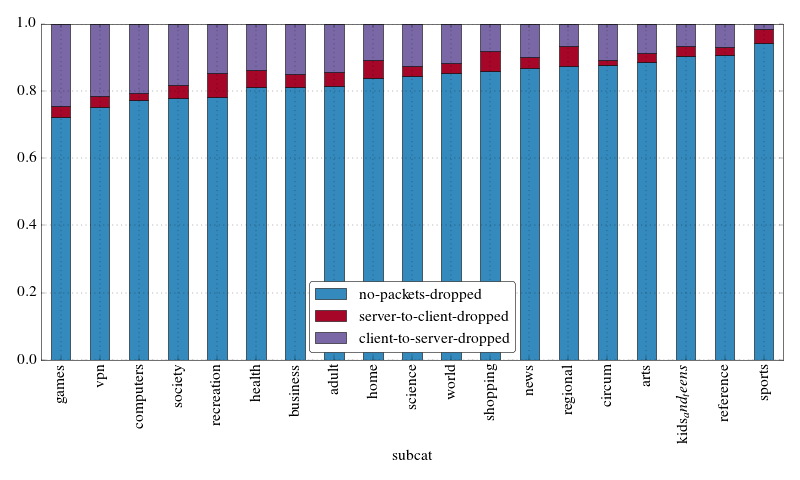

In [310]:
fig1, ax1 = plt.subplots(1,1, figsize=(10,6))
df = df_censorship[['case2', 'case1', 'case3']].rename(columns = {'case2':'no-packets-dropped',
                                                                  'case1':'server-to-client-dropped',
                                                                  'case3':'client-to-server-dropped'})
df.plot(kind='bar', stacked=True, ax=ax1)
ax1.legend(loc='best', prop={'size':14})
fig1.tight_layout()
fig1.savefig(RESULTS + "cases_ratio_by_subcat_stacked_bar")

# BY SUBCAT per COUNTRY and vice versa
- draw above plots for each country
- each subplot

In [312]:
df_censorship = df_case_count.reset_index().groupby(['subcat', 'country']).sum()
df_censorship = df_censorship.rename( columns= {k:str(k) for k in df_censorship.columns} )
#df_censorship['total_err'] = df_censorship[['0','4']].sum(axis=1)
#df_censorship['total'] = df_censorship['total'] - df_censorship['total_err']
df_censorship = df_censorship[['1','3','2','total']]
df_censorship['case1'] = df_censorship['1']/df_censorship['total'] 
df_censorship['case3'] = df_censorship['3']/df_censorship['total'] 
df_censorship['case2'] = df_censorship['2']/df_censorship['total'] 
#df_censorship['case04'] = df_censorship['total_err']/df_censorship['total']

In [313]:
df_censorship = df_censorship.reset_index()

<IPython.core.display.Javascript object>


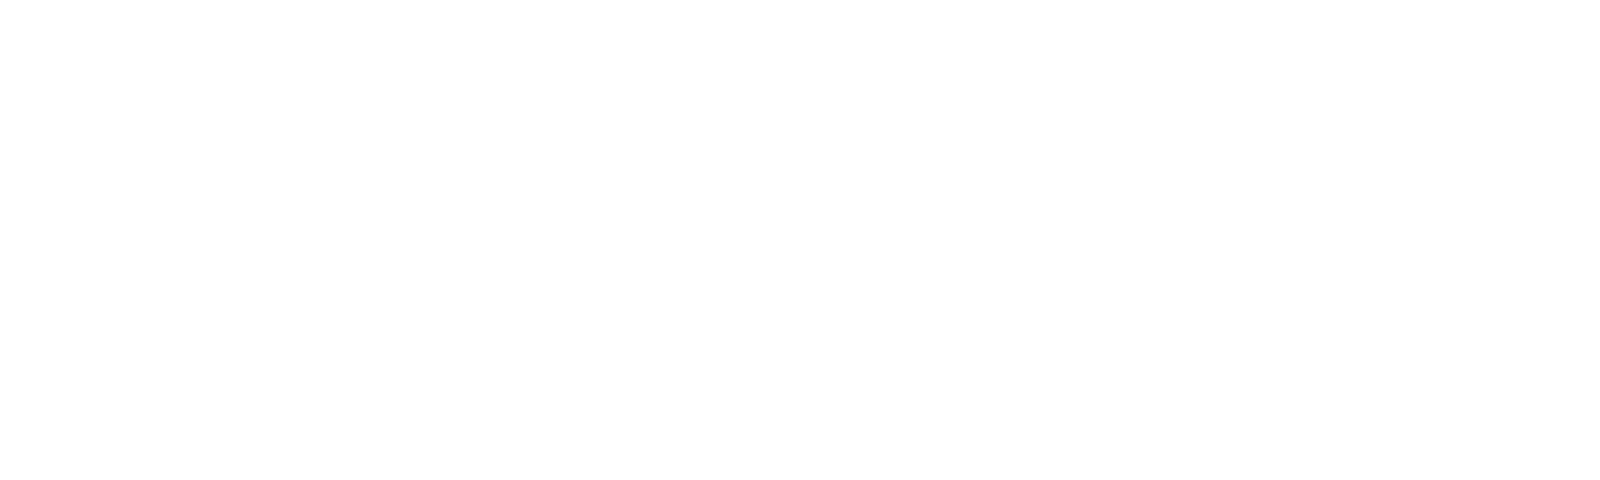

<IPython.core.display.Javascript object>


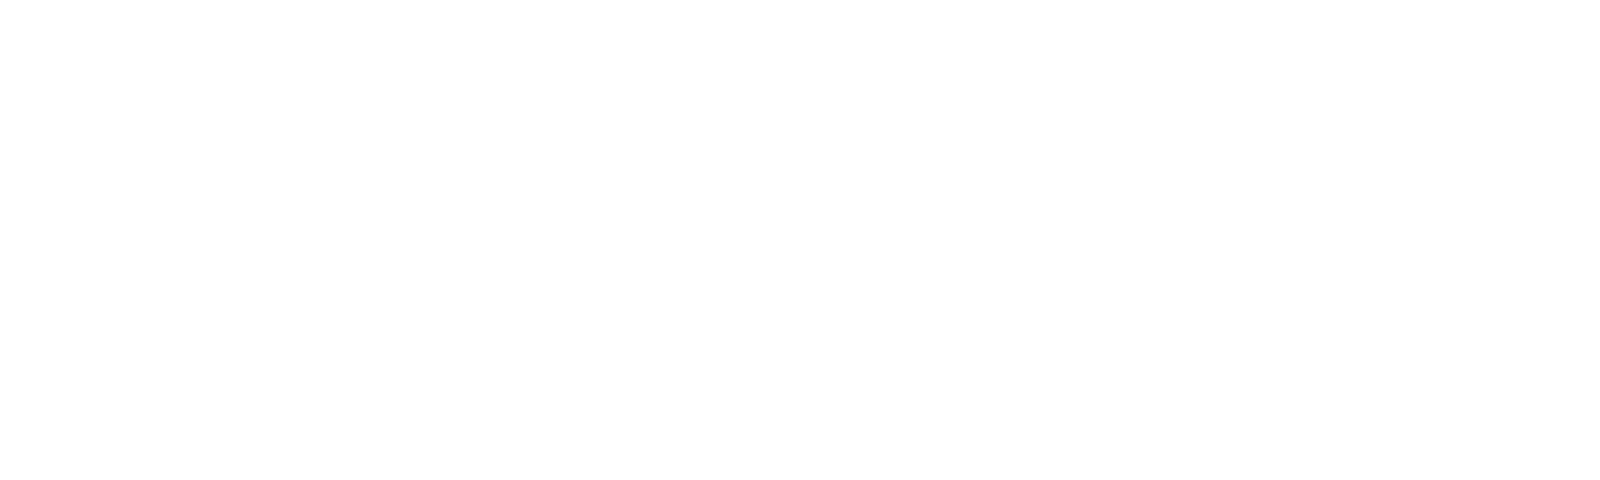

<IPython.core.display.Javascript object>


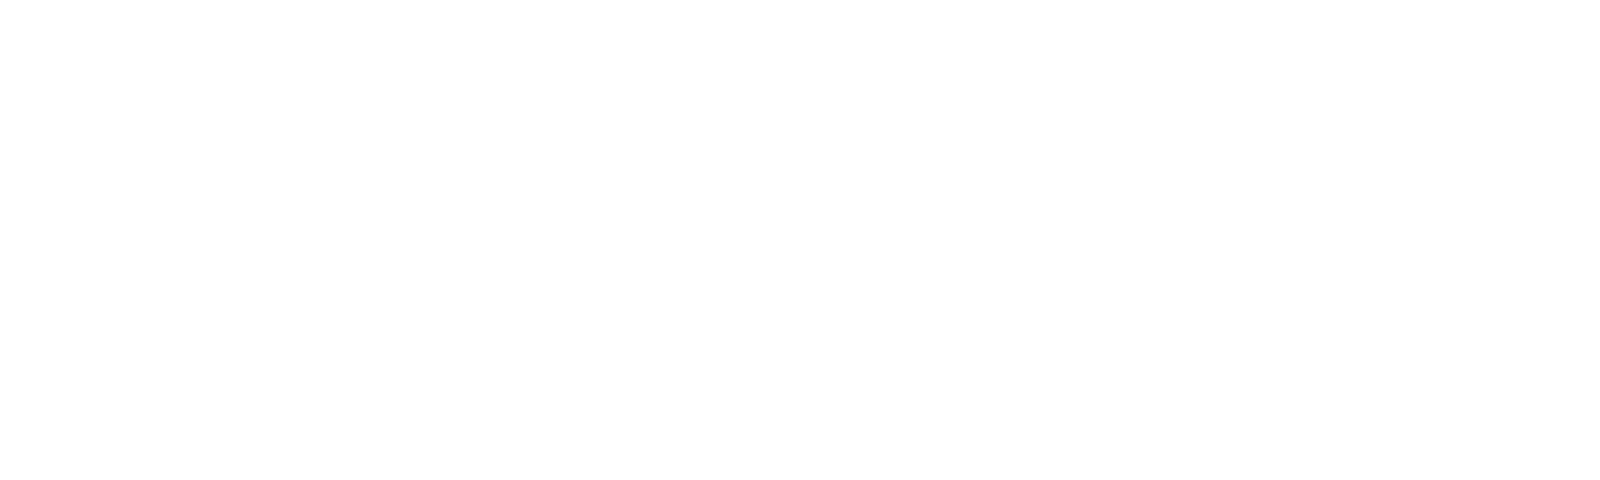

<IPython.core.display.Javascript object>


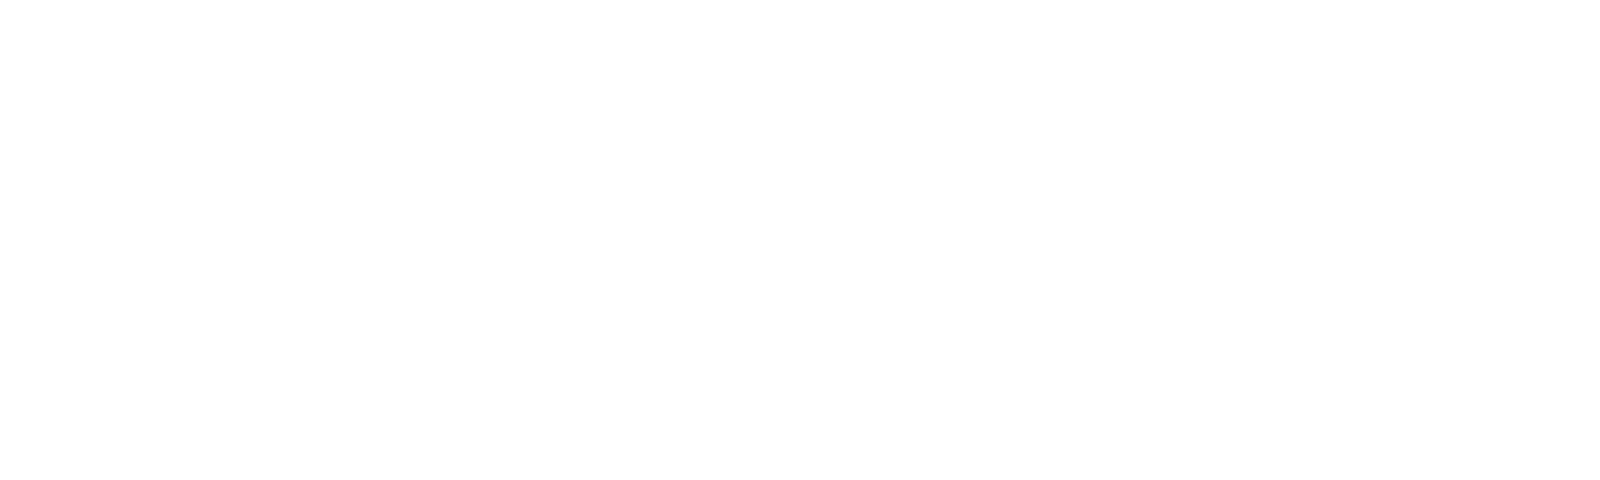

<IPython.core.display.Javascript object>


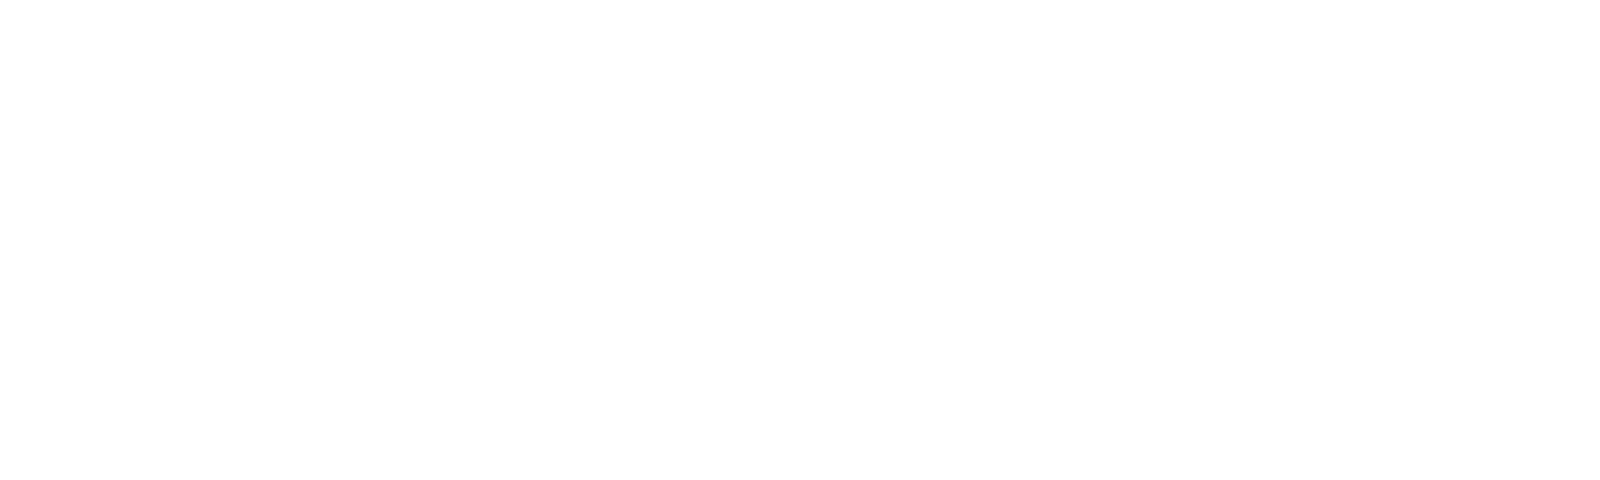

<IPython.core.display.Javascript object>


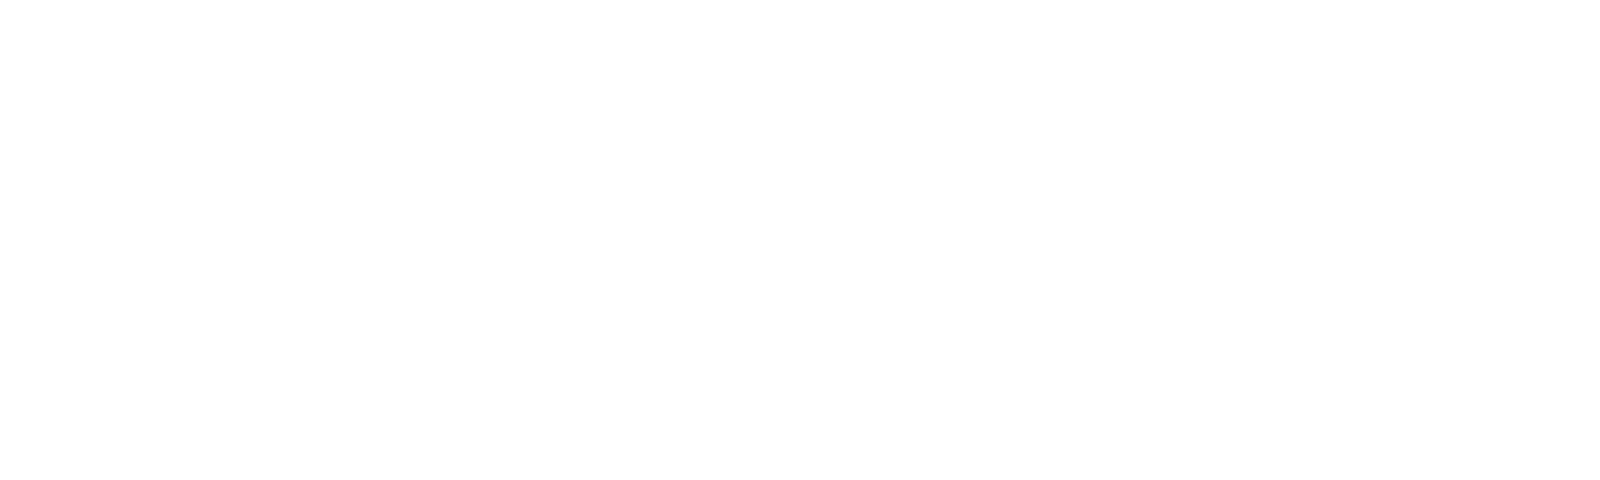

<IPython.core.display.Javascript object>


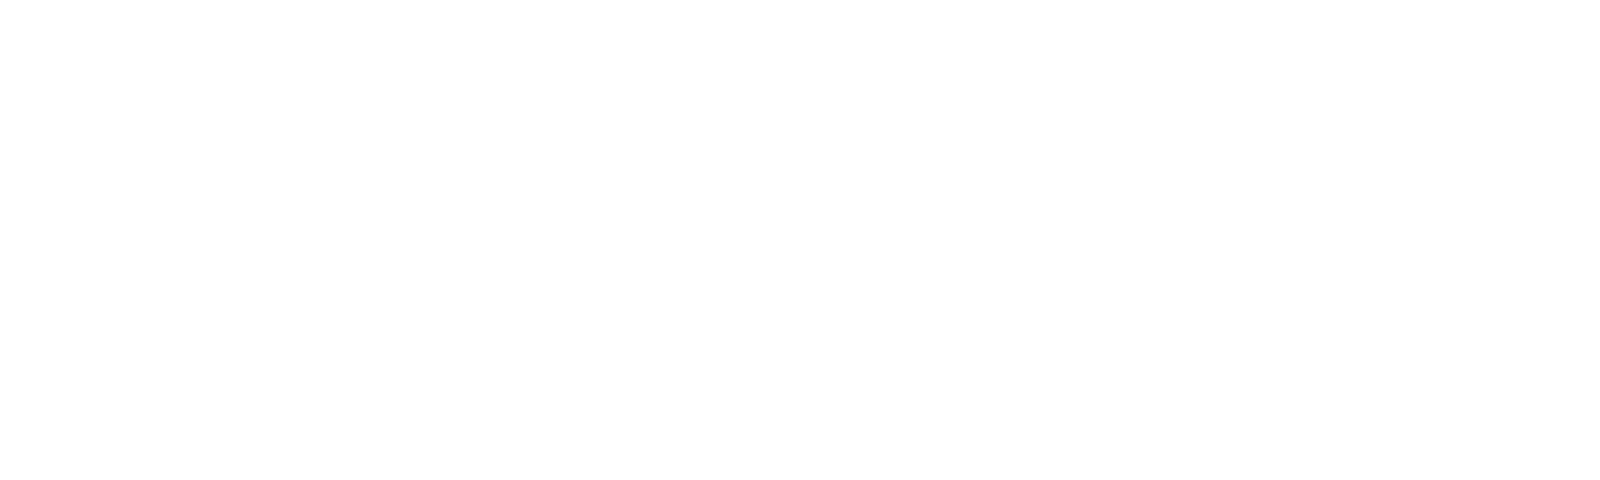

<IPython.core.display.Javascript object>


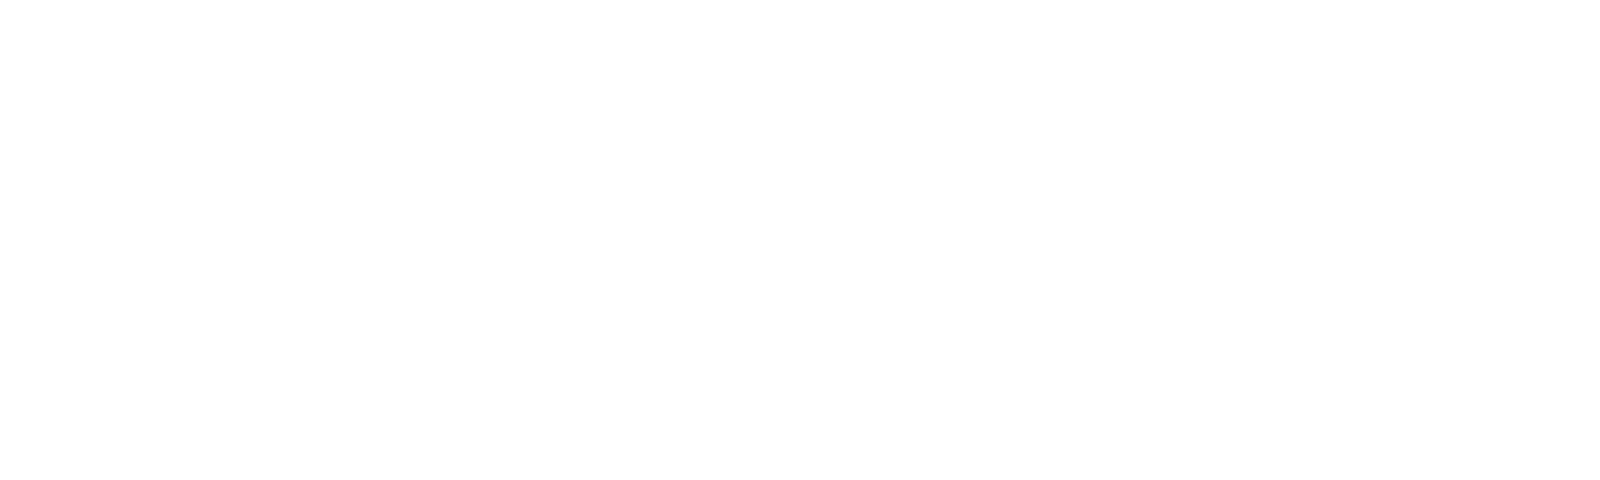

<IPython.core.display.Javascript object>


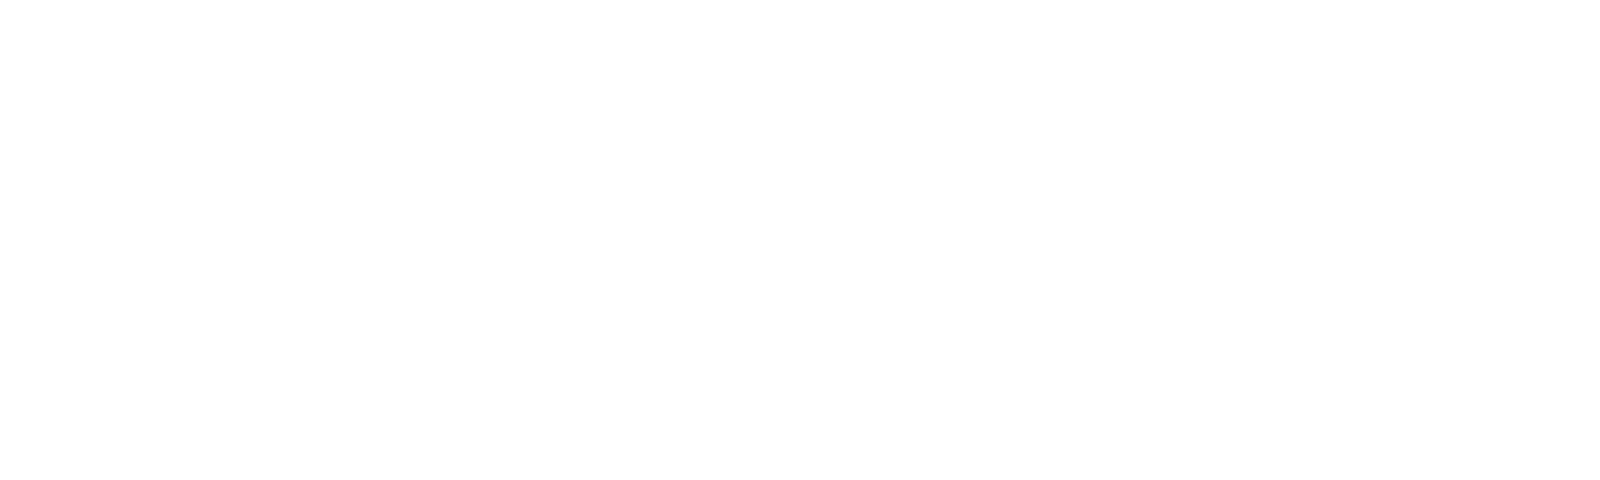

<IPython.core.display.Javascript object>


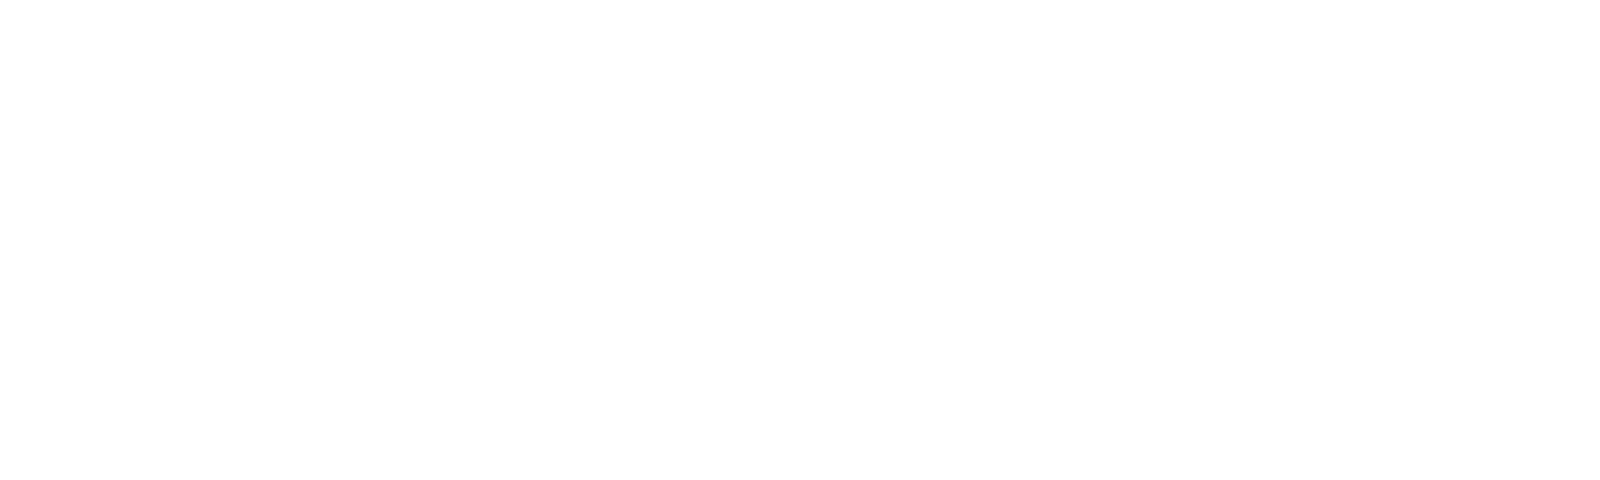

<IPython.core.display.Javascript object>


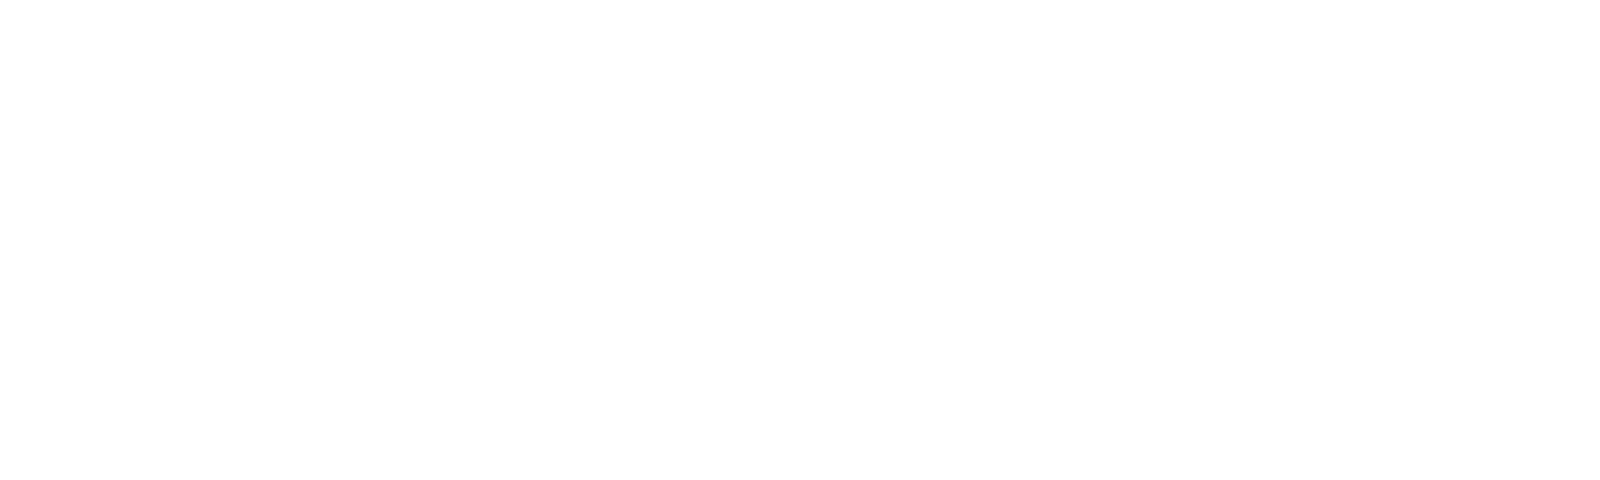

<IPython.core.display.Javascript object>


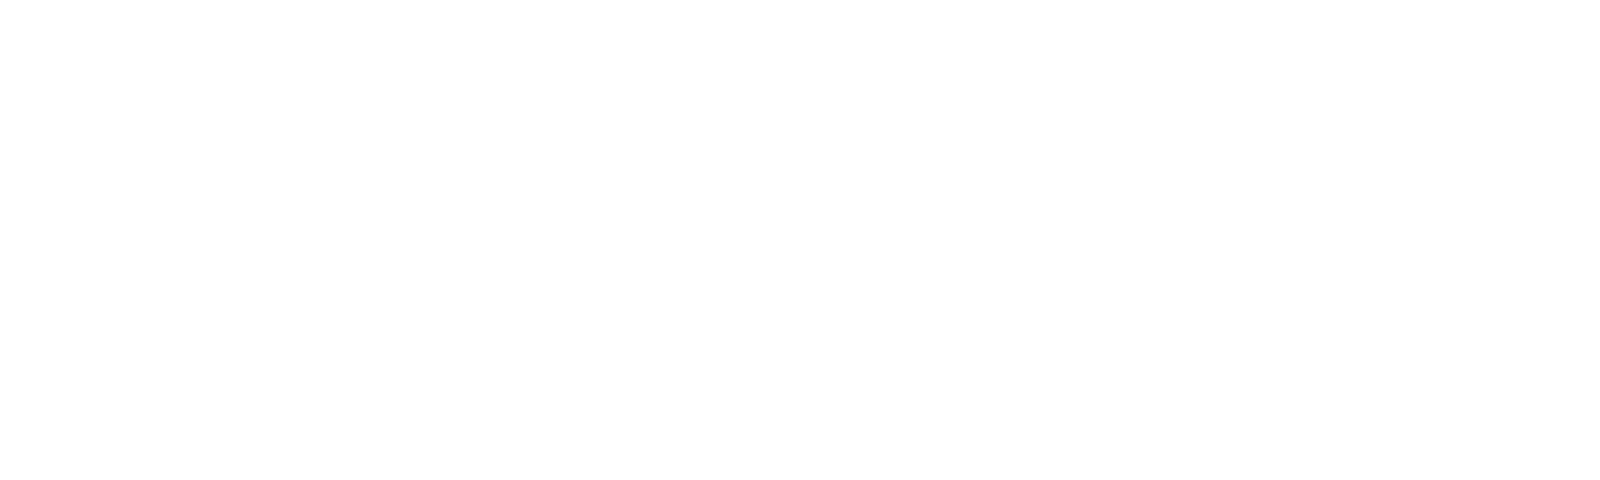

<IPython.core.display.Javascript object>


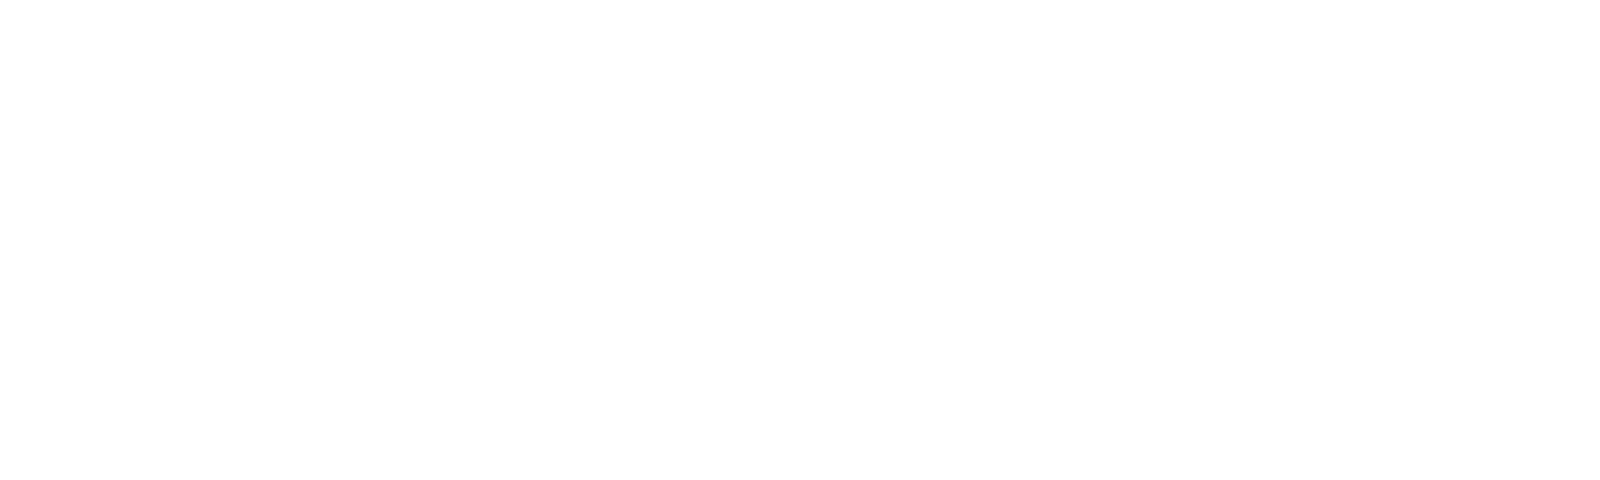

<IPython.core.display.Javascript object>


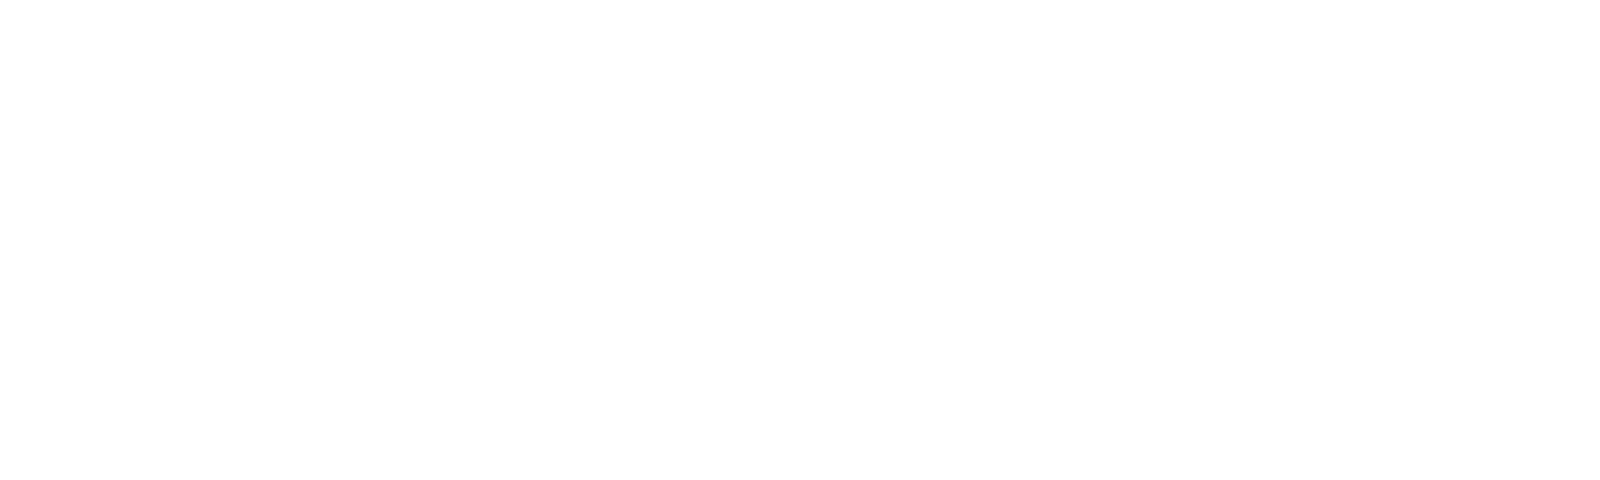

<IPython.core.display.Javascript object>


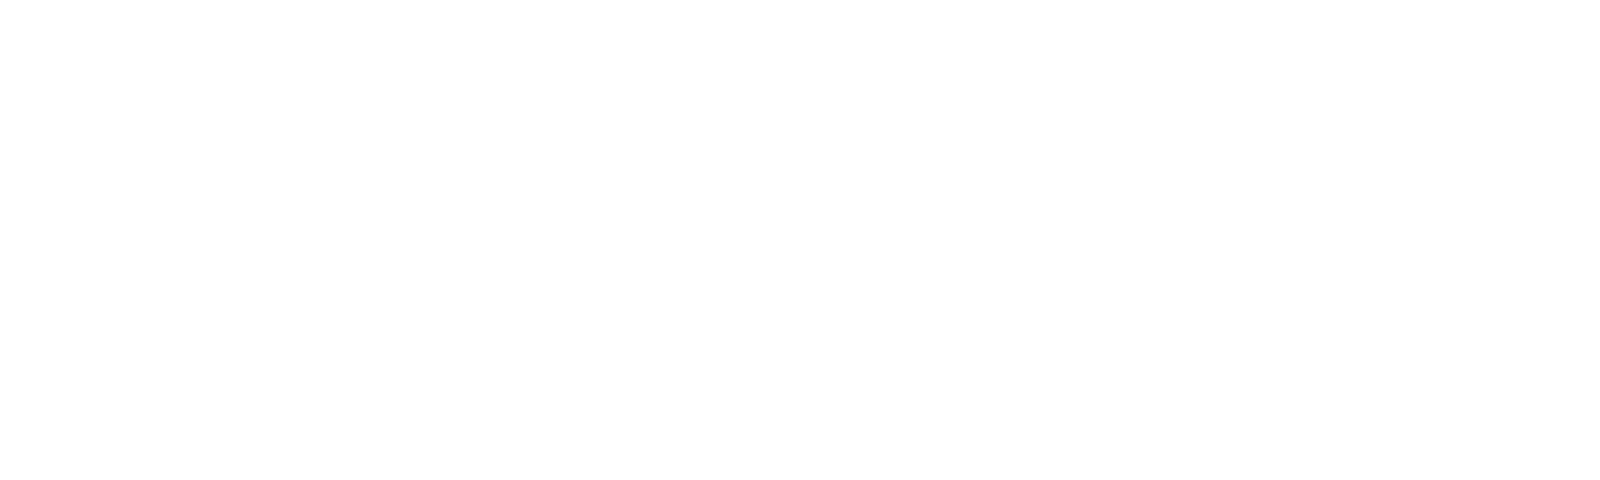

<IPython.core.display.Javascript object>


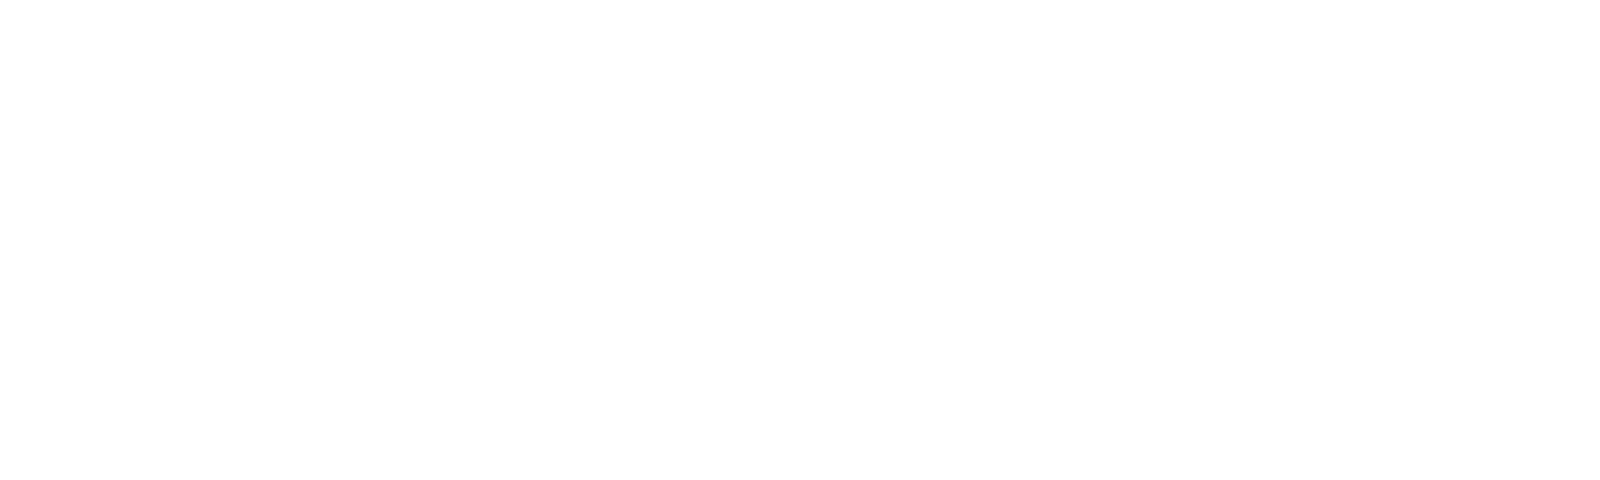

<IPython.core.display.Javascript object>


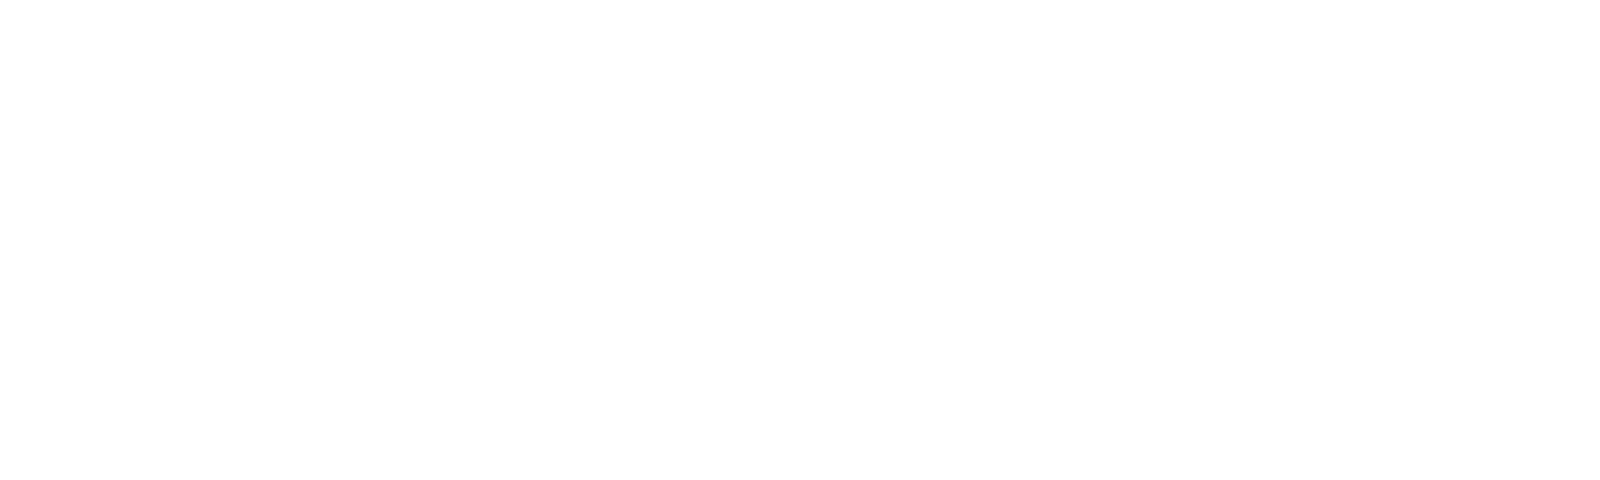

<IPython.core.display.Javascript object>


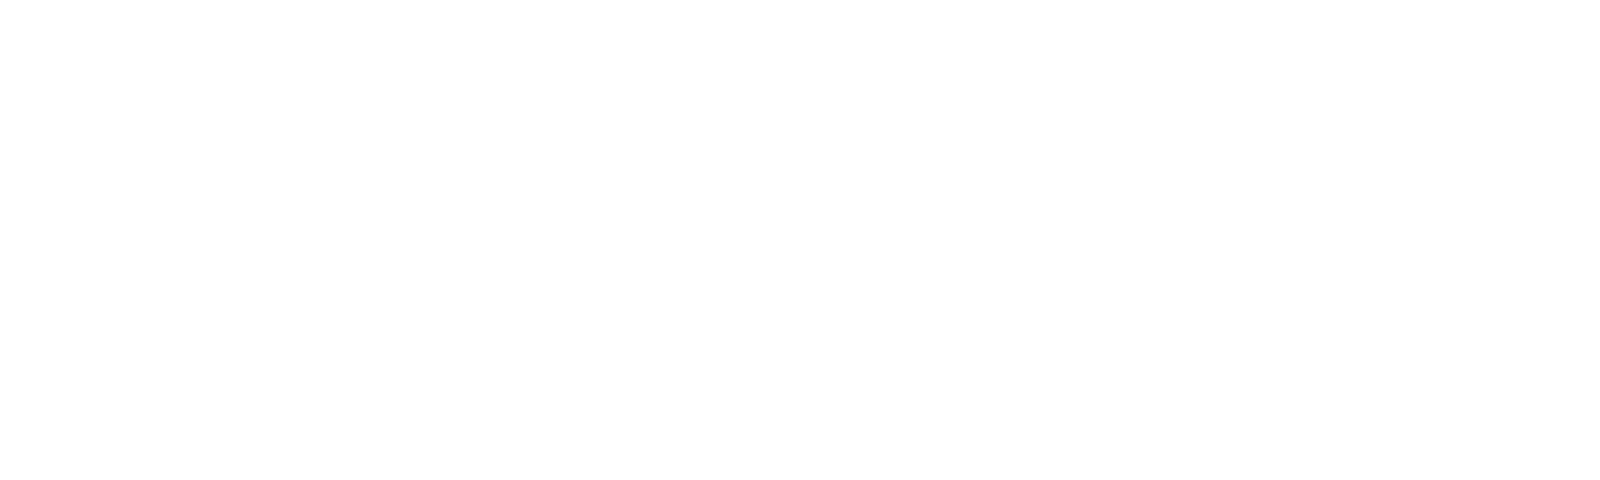

<IPython.core.display.Javascript object>


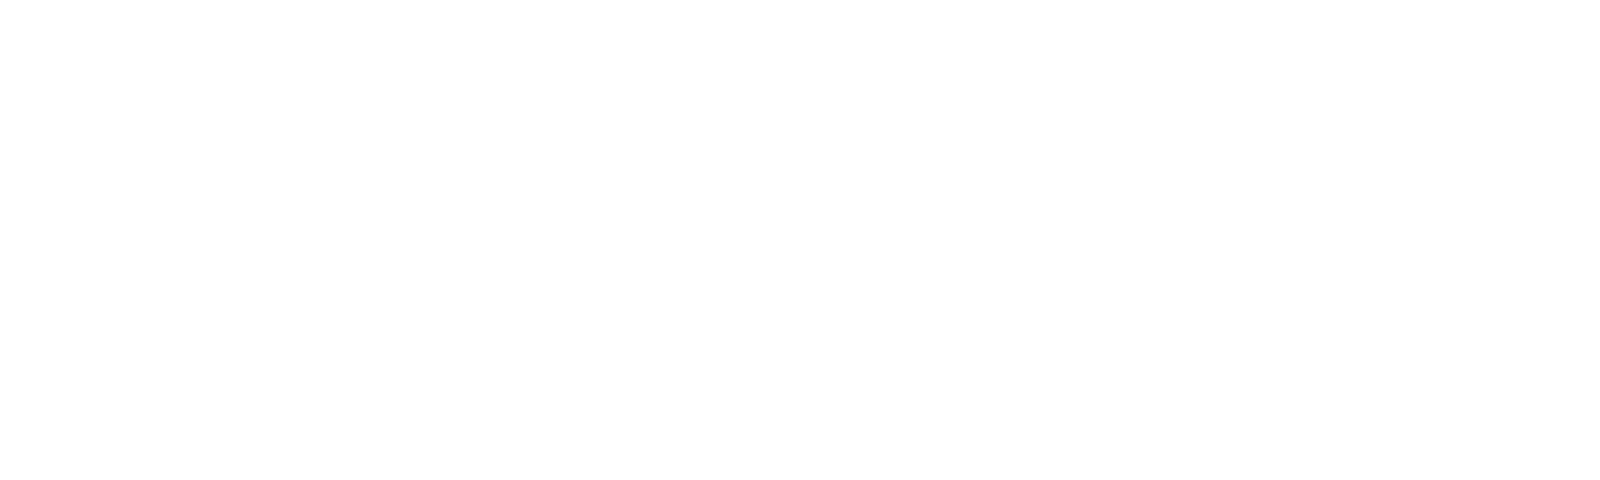

In [314]:
currFolder = RESULTS + "subcat/"
if not os.path.exists(currFolder):
    os.makedirs(currFolder)

for subcat in df_censorship.subcat.unique():
    
    df_per_subcat = df_censorship[ df_censorship['subcat']==subcat ].sort('case2')
    
    #fig1, ax1 = plt.subplits(1, 1, figsize=(10,7))
    fig1, ax1 = plt.subplots(1,1, figsize=(20,6))
    df = df_per_subcat.set_index('country')[['case2', 'case1','case3']].rename({'case2':'no-packets-dropped',
                                                                  'case1':'server-to-client-dropped',
                                                                  'case3':'client-to-server-dropped'})
    df.plot(kind='bar', stacked=True, ax=ax1)
    ax1.legend(loc='best', prop={'size':14})
    fig1.tight_layout()
    fig1.savefig(currFolder + "cases_ratio_by_country_stacked_bar_"+subcat)
    plt.close()

# PCA

In [315]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

In [316]:
tsne = TSNE(n_components=2, random_state=0)
pca = PCA(n_components=2)

In [221]:
df_censorship.subcat.unique()

array(['adult', 'arts', 'business', 'circum', 'computers', 'games',
       'health', 'home', 'kids_and_teens', 'news', 'recreation',
       'reference', 'regional', 'science', 'shopping', 'society', 'sports',
       'vpn', 'world'], dtype=object)

In [317]:
df_filtered = df_censorship[['subcat','country','case1','case2','case3']].copy()
df_filtered['case1/case13'] = df_filtered['case1']/( df_filtered['case1'] + df_filtered['case3'] )
df_filtered2 = df_filtered[['subcat','country','case1','case2','case3']]
df_filtered3 = df_filtered[['subcat','country','case1/case13','case2']]

In [318]:
df_multidim2 = df_filtered2.pivot(index='country', columns='subcat')
df_multidim3 = df_filtered3.pivot(index='country', columns='subcat')

In [319]:
df_multidim3

case    case1/case13                                                    \
subcat         adult      arts  business    circum computers     games   
country                                                                  
AE          0.500000  0.600000  0.400000  0.500000  0.200000  0.000000   
AF          0.500000  0.500000  0.428571  0.333333  0.307692  0.300000   
AL          0.666667  0.875000  0.636364  1.000000  0.500000  0.769231   
AM          0.250000  0.250000  0.111111       NaN  0.000000  0.000000   
AO          0.166667  0.000000  0.333333  0.333333  0.181818  0.000000   
AR          0.000000  0.200000  0.222222  0.000000  0.000000  0.000000   
AT          0.166667  0.333333  0.400000  0.000000  0.111111  0.125000   
AU          0.500000  0.000000  0.250000  0.000000  0.400000  0.000000   
AZ          0.250000  0.250000  0.600000  0.000000  0.300000  0.000000   
BA          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
BD          0.000000  0.250000  0.000000  0.333333  0.000000  0.125000   
BE          0.166667  0.250000  0.181818  0.333333  0.090909  0.181818   
BF          0.000000  0.200000  0.000000  0.000000  0.000000  0.000000   
BG          0.000000  0.200000  0.125000  0.000000  0.083333  0.000000   
BH          0.000000  0.000000  0.111111  0.000000  0.000000  0.000000   
BI          0.000000  0.200000  0.111111  0.000000  0.000000  0.000000   
BJ          0.000000  0.000000  0.400000  0.000000  0.090909  0.125000   
BO          0.200000  0.400000  0.400000  0.000000  0.083333  0.000000   
BW          0.000000  0.000000  0.111111  0.000000  0.000000  0.000000   
BY          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
CA          0.333333  0.400000  0.333333  0.000000  0.266667  0.000000   
CD          0.000000  0.000000  0.142857  0.000000  0.000000  0.000000   
CG          0.400000  0.700000  0.600000  0.500000  0.384615  0.250000   
CH          0.428571  0.250000  0.454545  1.000000  0.400000  0.000000   
CI          0.000000  0.000000  0.285714  0.000000  0.000000  0.000000   
CL          0.000000  0.200000  0.000000  0.000000  0.083333  0.000000   
CM          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
CN          0.400000  0.200000  0.333333  0.875000  0.400000  0.111111   
CO          0.166667  0.000000  0.125000  0.000000  0.000000  0.142857   
CR          0.166667  0.000000  0.111111  0.000000  0.000000  0.000000   
...              ...       ...       ...       ...       ...       ...   
SD          0.166667  0.000000  0.400000  0.000000  0.166667  0.111111   
SE          0.100000  0.000000  0.076923  0.000000  0.000000  0.000000   
SG          0.200000  0.333333  0.333333  0.500000  0.222222  0.000000   
SI          0.333333  0.000000  0.000000  0.000000  0.000000  0.000000   
SK          0.090909  0.000000  0.090909  0.000000  0.000000  0.000000   
SL          0.166667  0.000000  0.111111  0.000000  0.000000  0.000000   
SN          0.285714  0.000000  0.166667  0.000000  0.000000  0.125000   
SO          0.200000  0.000000  0.100000  0.000000  0.000000  0.000000   
SV          0.400000  0.000000  0.125000  0.000000  0.111111  0.000000   
SY          0.142857  0.000000  0.400000  0.000000  0.166667  0.111111   
SZ          0.142857  0.000000  0.111111  0.000000  0.000000  0.000000   
TG          0.166667  0.000000  0.125000  0.000000  0.000000  0.000000   
TH          0.400000  0.000000  0.222222  0.000000  0.000000  0.125000   
TL          0.333333  0.000000  0.125000  0.333333  0.000000  0.000000   
TM          0.625000  0.900000  0.760000  0.500000  0.636364  0.562500   
TN          0.500000  0.500000  0.500000  0.000000  0.222222  0.300000   
TR          0.250000  0.636364  0.307692  0.000000  0.272727  0.111111   
TT          0.000000  0.000000  0.125000  0.000000  0.000000  0.000000   
TW          0.333333  0.000000  0.125000  0.000000  0.000000  0.000000   
TZ          0.200000  0.000000  0.111111  0.000000  0.000000  0.000000   
UA  

<IPython.core.display.Javascript object>


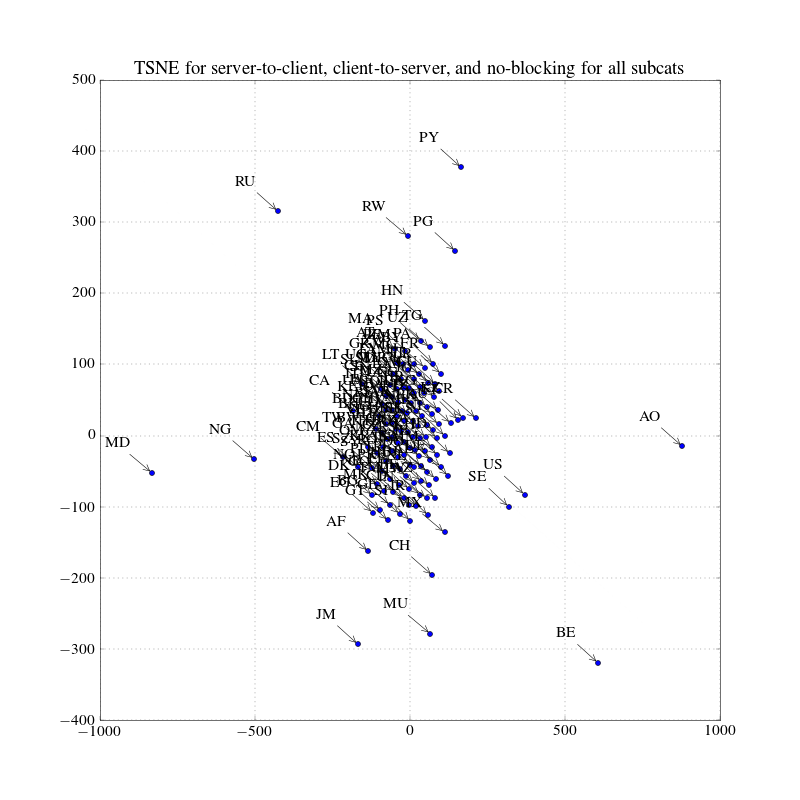

<IPython.core.display.Javascript object>


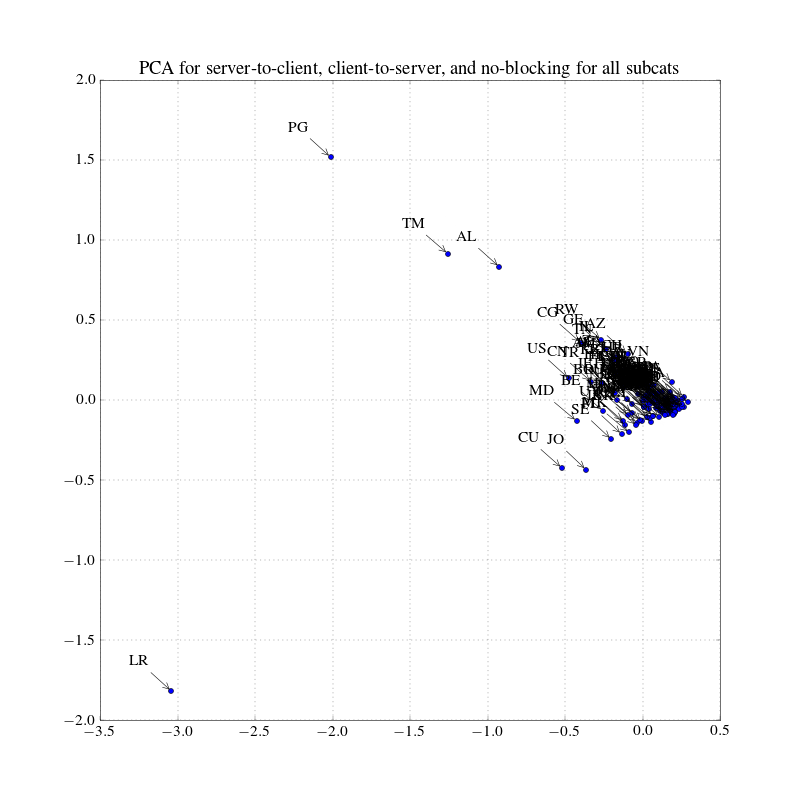

In [322]:
mat = df_multidim2.as_matrix()
df4 = pd.DataFrame(tsne.fit_transform(mat)).set_index(df_multidim.index)
fig2, ax2 = plt.subplots(1,1, figsize=(10,10))
ax2.scatter(df4[0], df4[1])
for label, x, y in zip(df4.index, df4[0], df4[1]):
    ax2.annotate(
        label, 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
ax2.grid(1)
ax2.set_title("TSNE for server-to-client, client-to-server, and no-blocking for all subcats")
fig2.savefig(currFolder + "tsne_countries_all_cols")
fig2.show()

mat = df_multidim2.as_matrix()
df4 = pd.DataFrame(pca.fit_transform(mat)).set_index(df_multidim.index)
fig2, ax2 = plt.subplots(1,1, figsize=(10,10))
ax2.scatter(df4[0], df4[1])
for label, x, y in zip(df4.index, df4[0], df4[1]):
    ax2.annotate(
        label, 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
ax2.grid(1)
ax2.set_title("PCA for server-to-client, client-to-server, and no-blocking for all subcats")
fig2.savefig(currFolder + "pca_countries_all_cols")
fig2.show()

In [323]:
mat = df_multidim3.as_matrix()
df4 = pd.DataFrame(tsne.fit_transform(mat)).set_index(df_multidim.index)
fig2, ax2 = plt.subplots(1,1, figsize=(10,10))
ax2.scatter(df4[0], df4[1])
for label, x, y in zip(df4.index, df4[0], df4[1]):
    ax2.annotate(
        label, 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
ax2.grid(1)
ax2.set_title("TSNE for ratio(server-to-client/total), and no-blocking for all subcats")
fig2.savefig(currFolder + "tsne_countries_ratios")
fig2.show()

mat = df_multidim3.as_matrix()
df4 = pd.DataFrame(pca.fit_transform(mat)).set_index(df_multidim.index)
fig2, ax2 = plt.subplots(1,1, figsize=(10,10))
ax2.scatter(df4[0], df4[1])
for label, x, y in zip(df4.index, df4[0], df4[1]):
    ax2.annotate(
        label, 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
ax2.grid(1)
ax2.set_title("PCA for ratio(server-to-client/total), and no-blocking  for all subcats")
fig2.savefig(currFolder + "pca_countries_ratios")
fig2.show()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


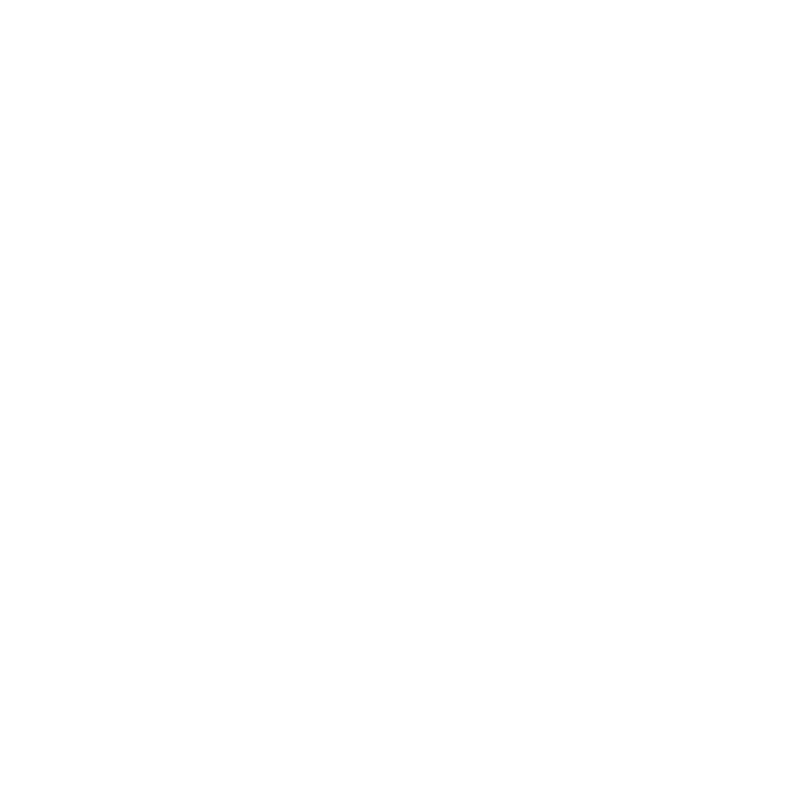

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


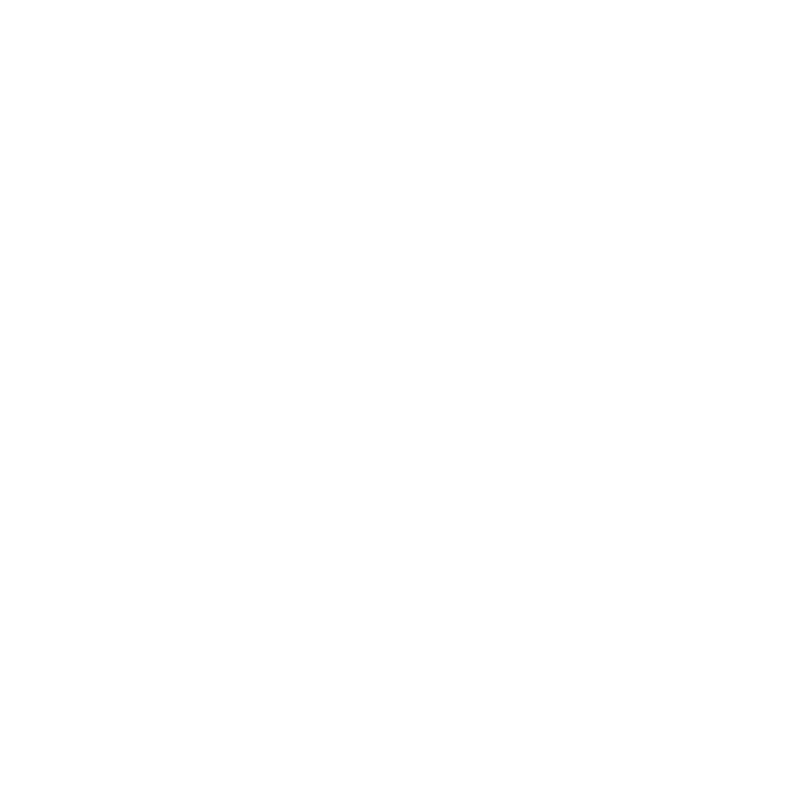

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


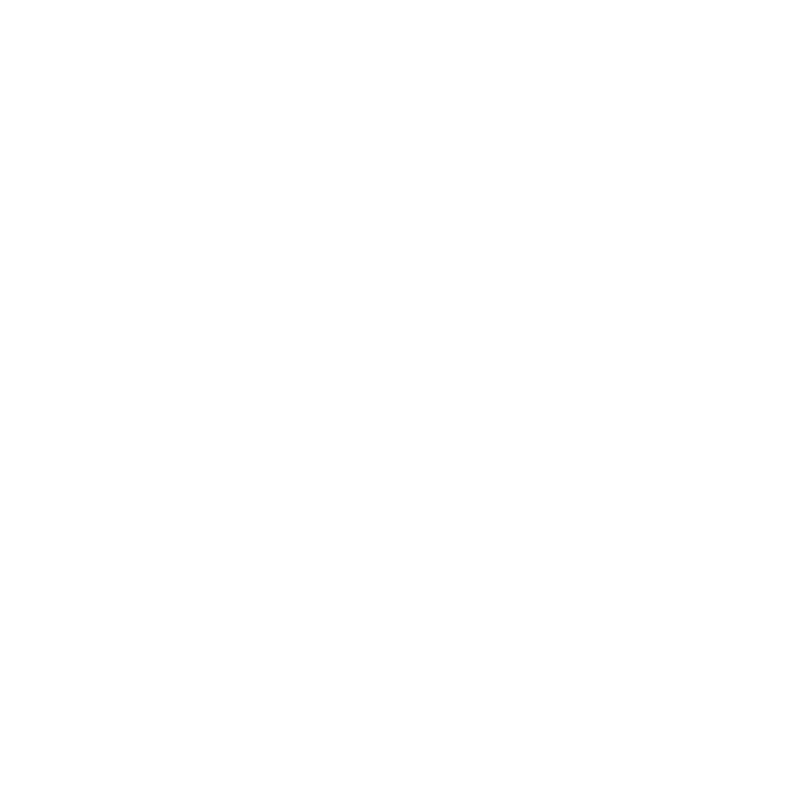

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


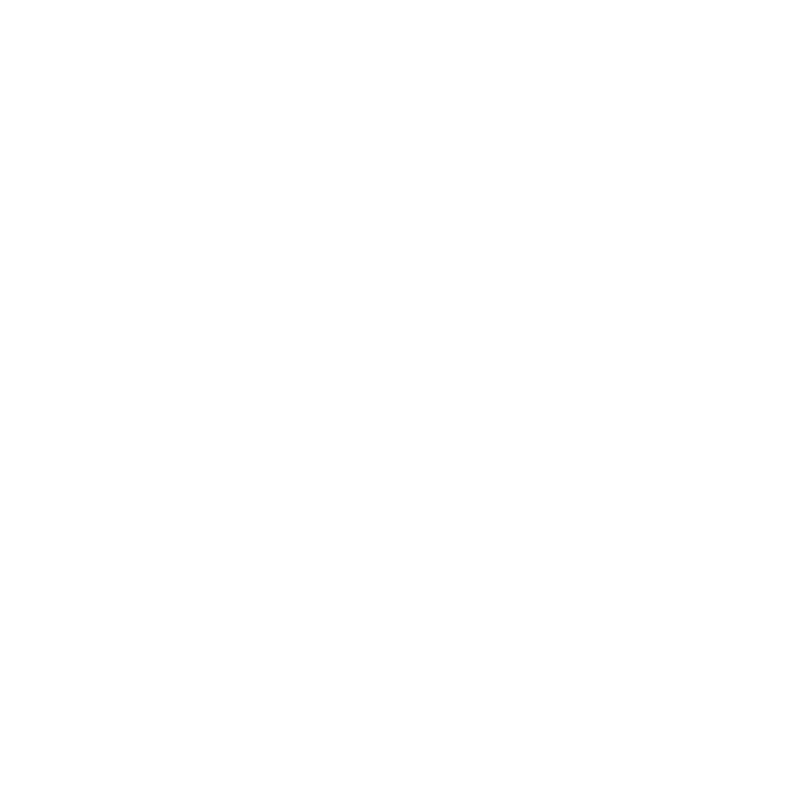

<IPython.core.display.Javascript object>

In [ ]:
#subcat = 'adult'

for subcat in df_censorship.subcat.unique():
    df = df_filtered[df_filtered['subcat']==subcat].set_index('country')[['case1','case2','case3']]
    mat = df.as_matrix()
    df4 = pd.DataFrame(pca.fit_transform(mat)).set_index(df.index)

    model = 'pca'
    fig2, ax2 = plt.subplots(1,1, figsize=(10,10))
    ax2.scatter(df4[0], df4[1])
    for label, x, y in zip(df4.index, df4[0], df4[1]):
        ax2.annotate(
            label, 
            xy = (x, y), xytext = (-20, 20),
            textcoords = 'offset points', ha = 'right', va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
    ax2.set_title(model + ' ' + subcat + ' case: 1,2,3')
    ax2.grid(1)
    fig2.savefig(RESULTS + "subcat/" + model + '-' + subcat)

    model = 'tsne'
    fig2, ax2 = plt.subplots(1,1, figsize=(10,10))
    ax2.scatter(df4[0], df4[1])
    for label, x, y in zip(df4.index, df4[0], df4[1]):
        ax2.annotate(
            label, 
            xy = (x, y), xytext = (-20, 20),
            textcoords = 'offset points', ha = 'right', va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
    ax2.set_title(model + ' ' + subcat + ' case: 1,2,3')
    ax2.grid(1)
    fig2.savefig(RESULTS + "subcat/" + model + '-' + subcat)

    plt.close()
#df_multidim = df.pivot(index='country', columns='subcat')

In [193]:
df_global = df_censorship.groupby('subcat')[['1','2','3', 'total']].sum()
df_global['1'] = df_global['1']/df_global['total']
df_global['2'] = df_global['2']/df_global['total']
df_global['3'] = df_global['3']/df_global['total']
df_global = df_global[['1','2','3']]


<IPython.core.display.Javascript object>


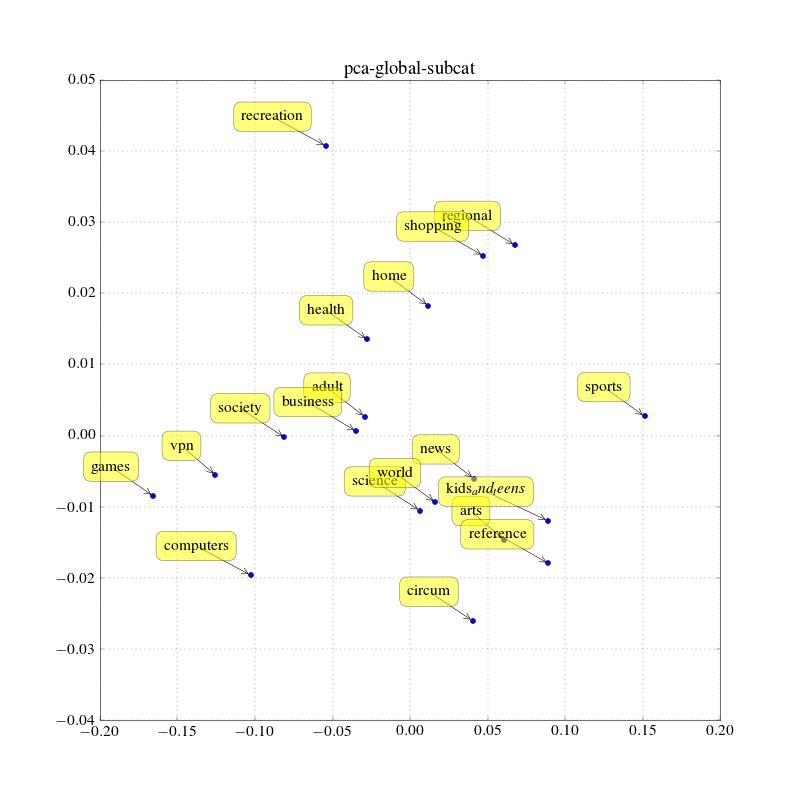

<IPython.core.display.Javascript object>


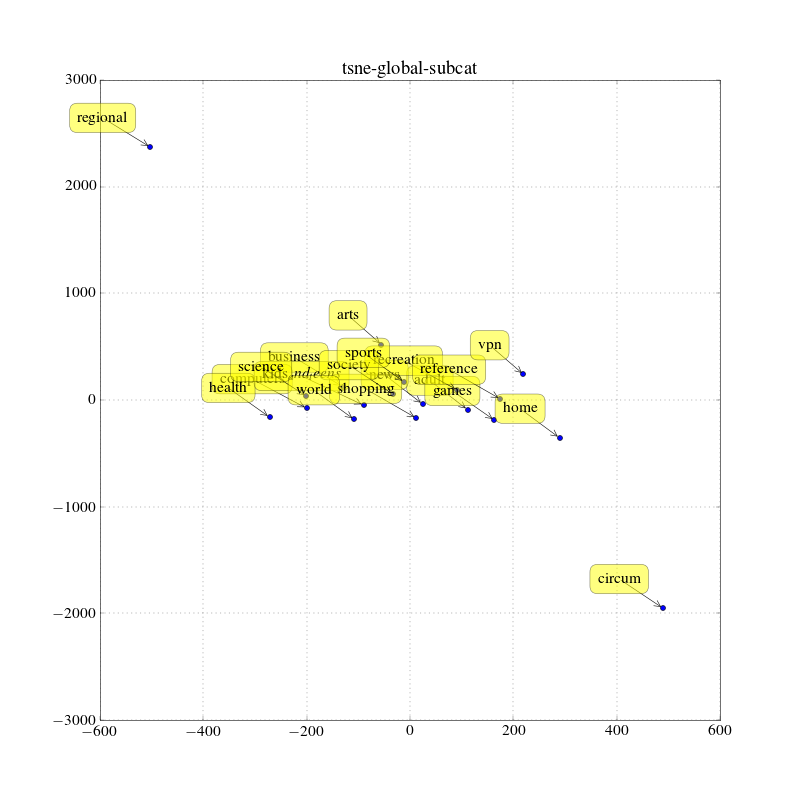

In [194]:

mat = df_global.as_matrix()

model = 'pca'
df4 = pd.DataFrame(pca.fit_transform(mat)).set_index(df_global.index)
fig2, ax2 = plt.subplots(1,1, figsize=(10,10))
ax2.scatter(df4[0], df4[1])
for label, x, y in zip(df4.index, df4[0], df4[1]):
    ax2.annotate(
        label, 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
ax2.grid(1)
ax2.set_title(model + '-global-subcat')
fig2.savefig(RESULTS + model + '-global-subcat')

model = 'tsne'
df4 = pd.DataFrame(tsne.fit_transform(mat)).set_index(df_global.index)
fig2, ax2 = plt.subplots(1,1, figsize=(10,10))
ax2.scatter(df4[0], df4[1])
for label, x, y in zip(df4.index, df4[0], df4[1]):
    ax2.annotate(
        label, 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
ax2.grid(1)
ax2.set_title(model + '-global-subcat')
fig2.savefig(RESULTS + model + '-global-subcat')

<IPython.core.display.Javascript object>


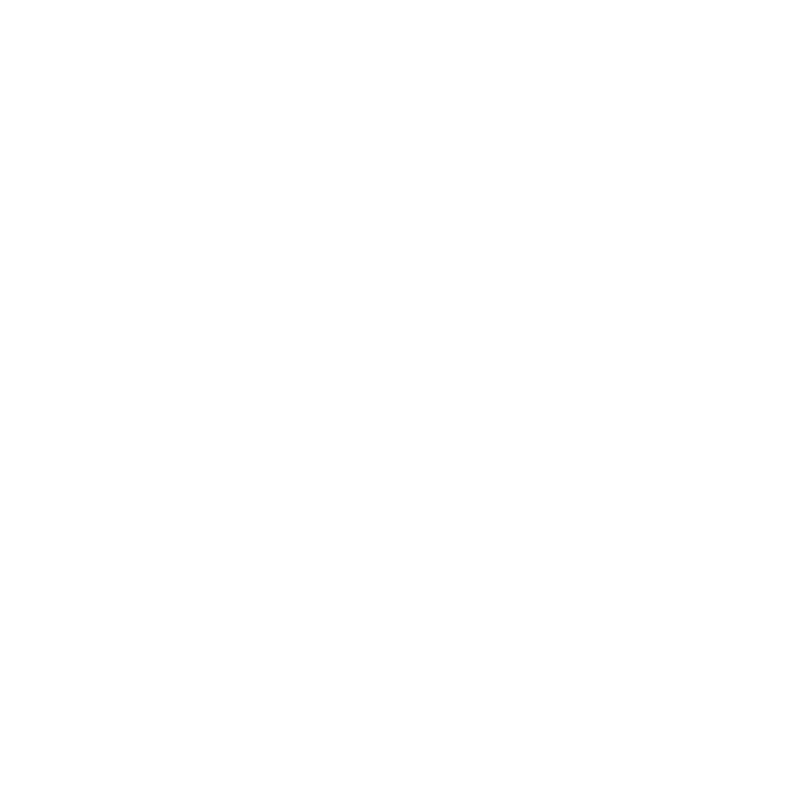

<IPython.core.display.Javascript object>


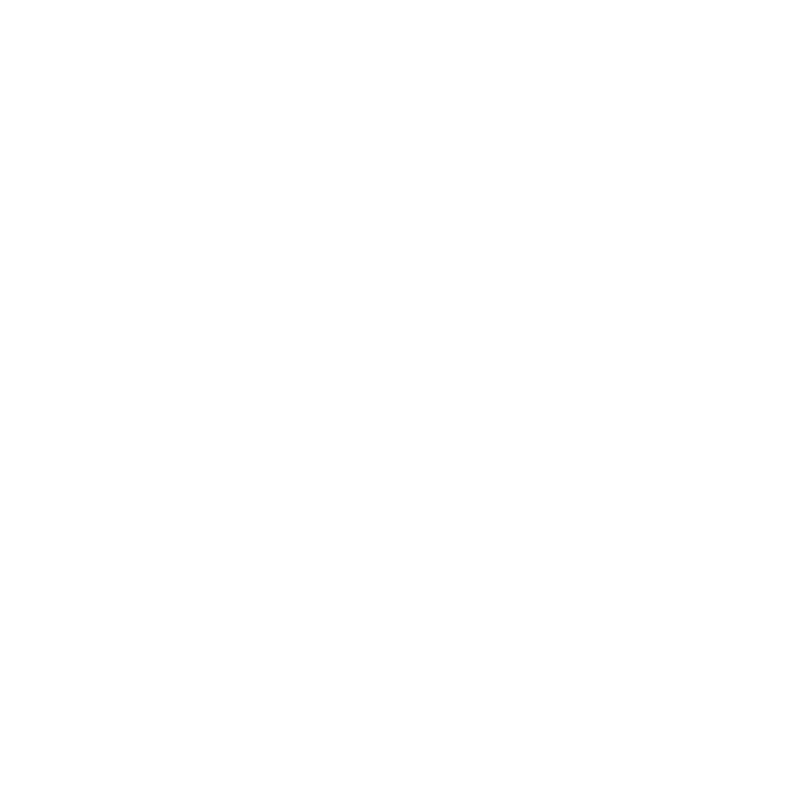

<IPython.core.display.Javascript object>


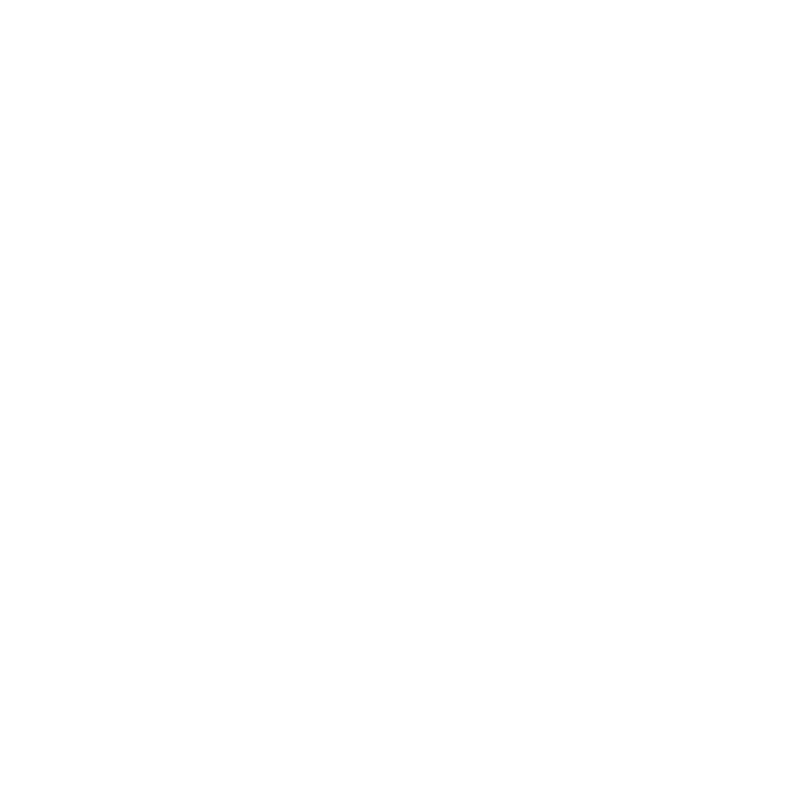

<IPython.core.display.Javascript object>


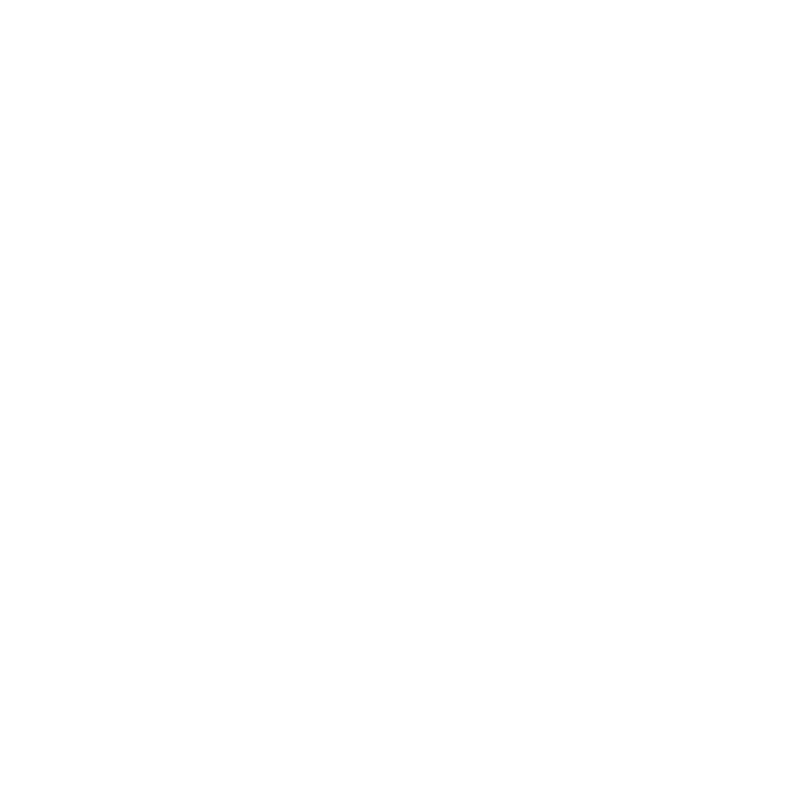

<IPython.core.display.Javascript object>


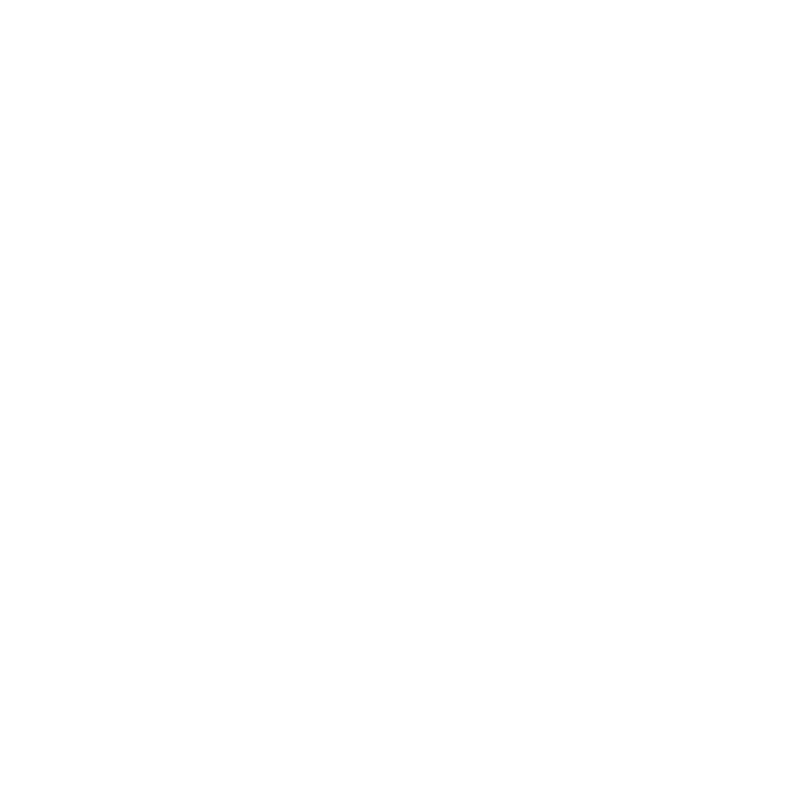

<IPython.core.display.Javascript object>


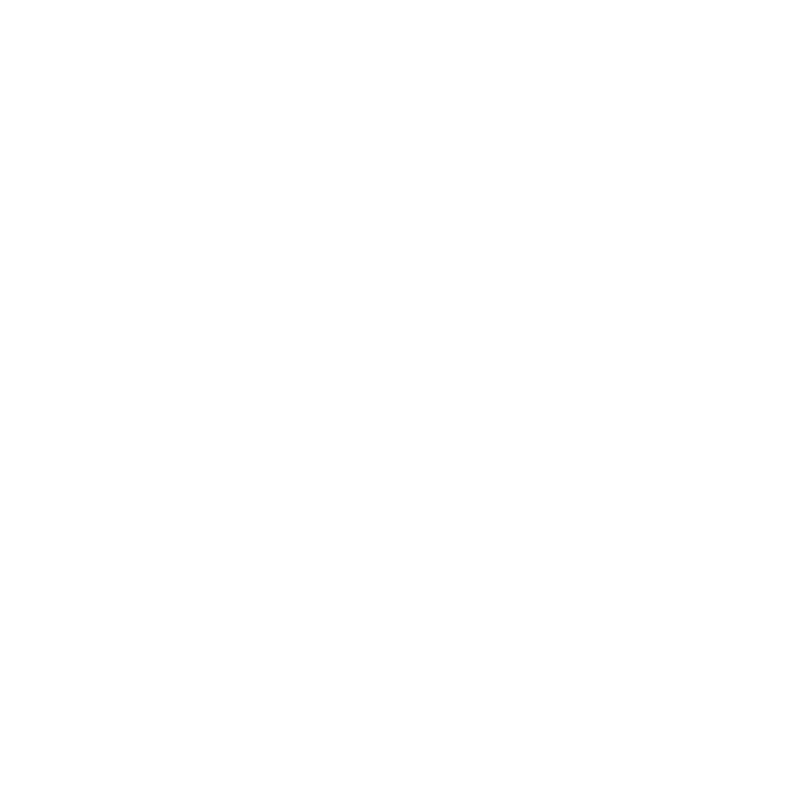

<IPython.core.display.Javascript object>


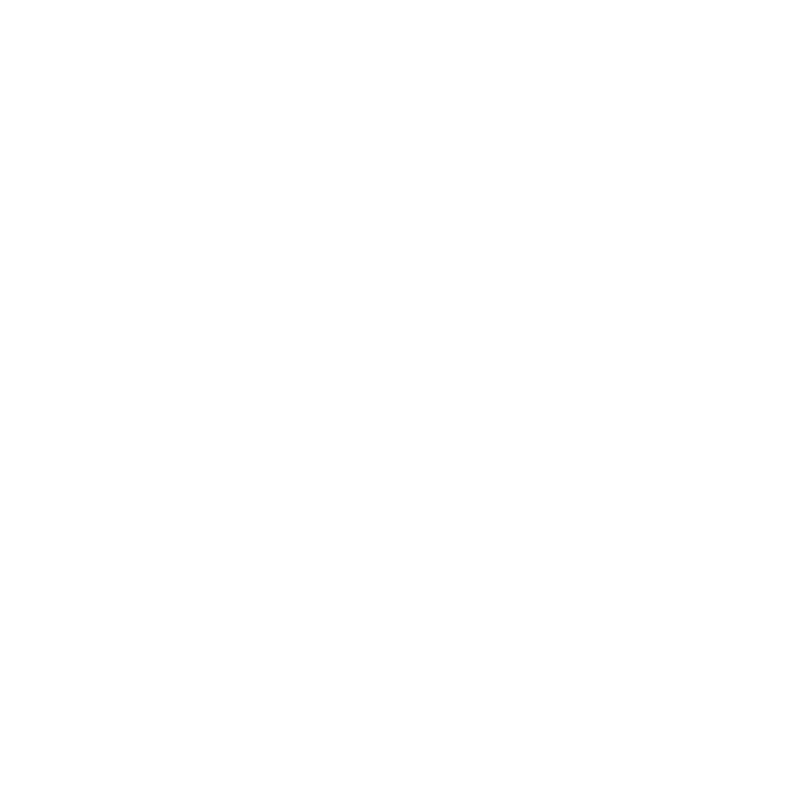

<IPython.core.display.Javascript object>


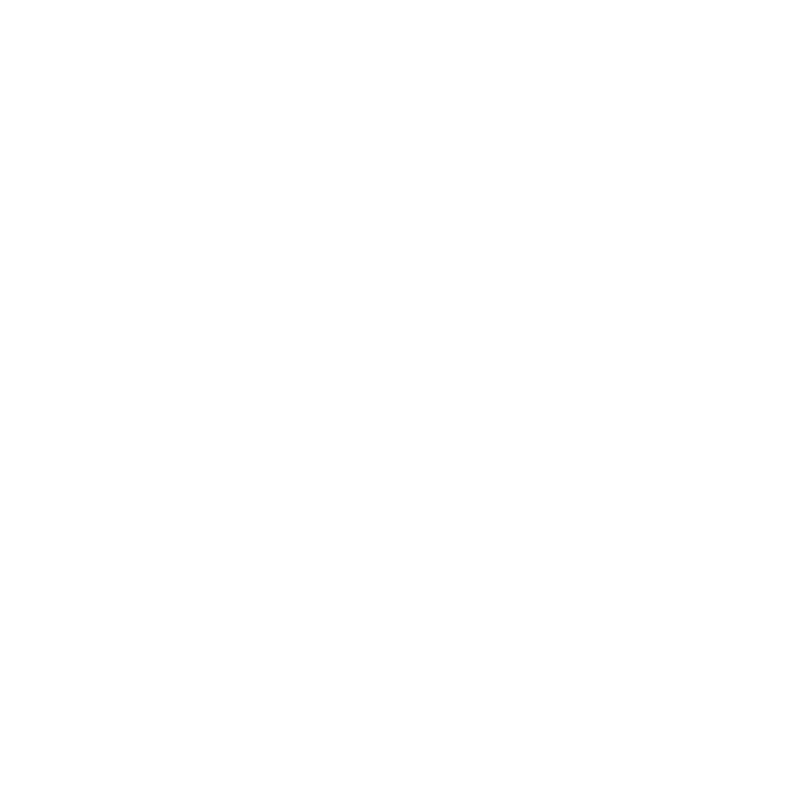

<IPython.core.display.Javascript object>


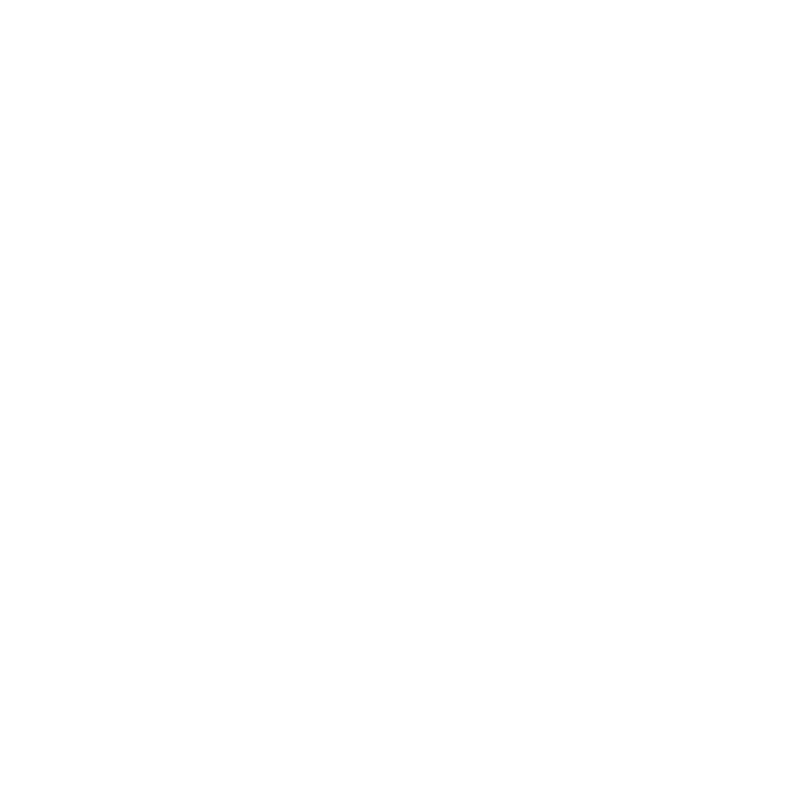

<IPython.core.display.Javascript object>


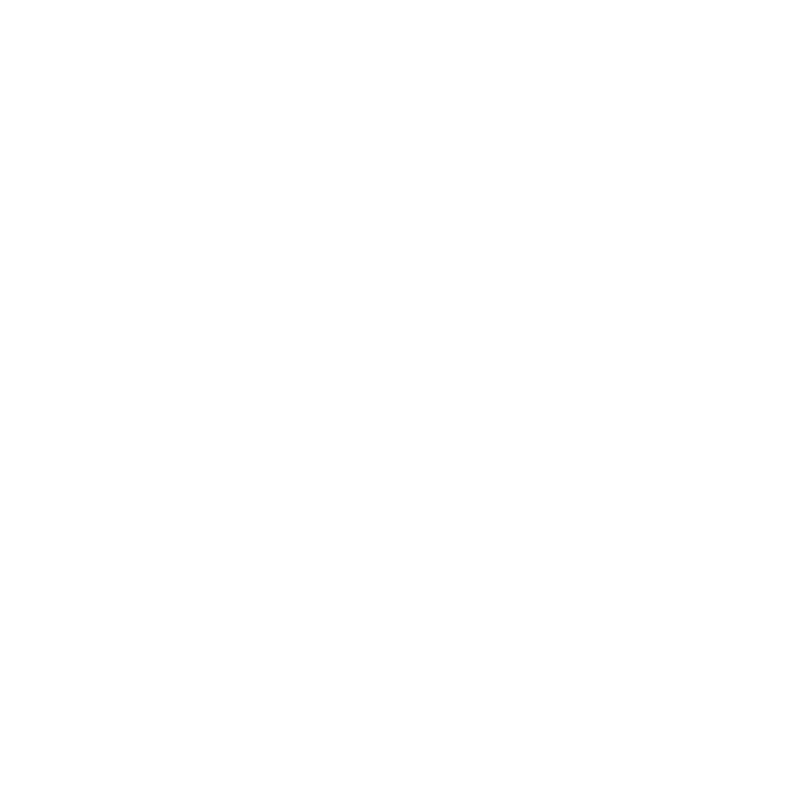

<IPython.core.display.Javascript object>


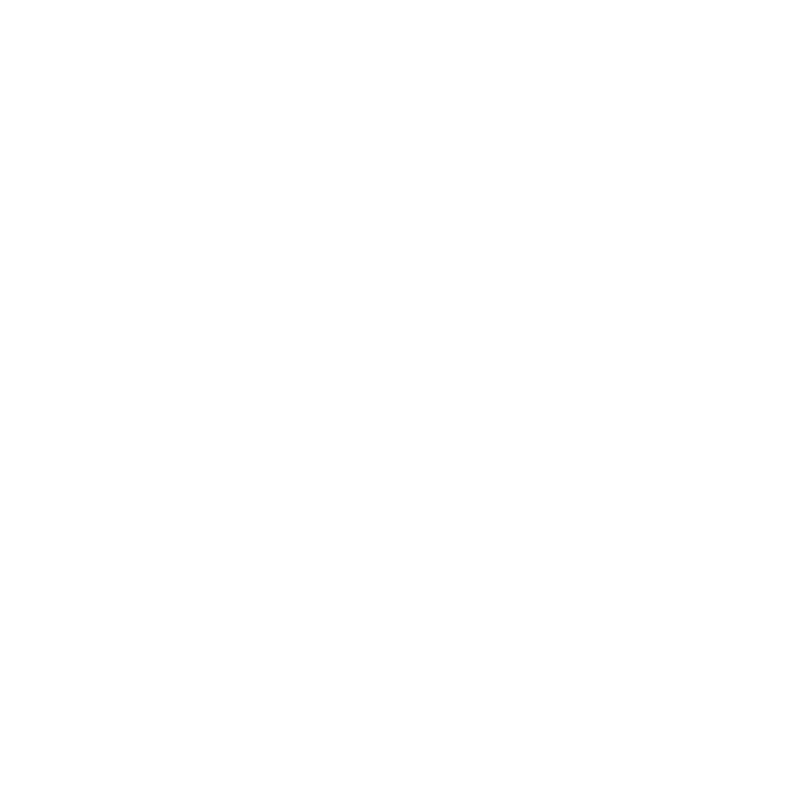

<IPython.core.display.Javascript object>


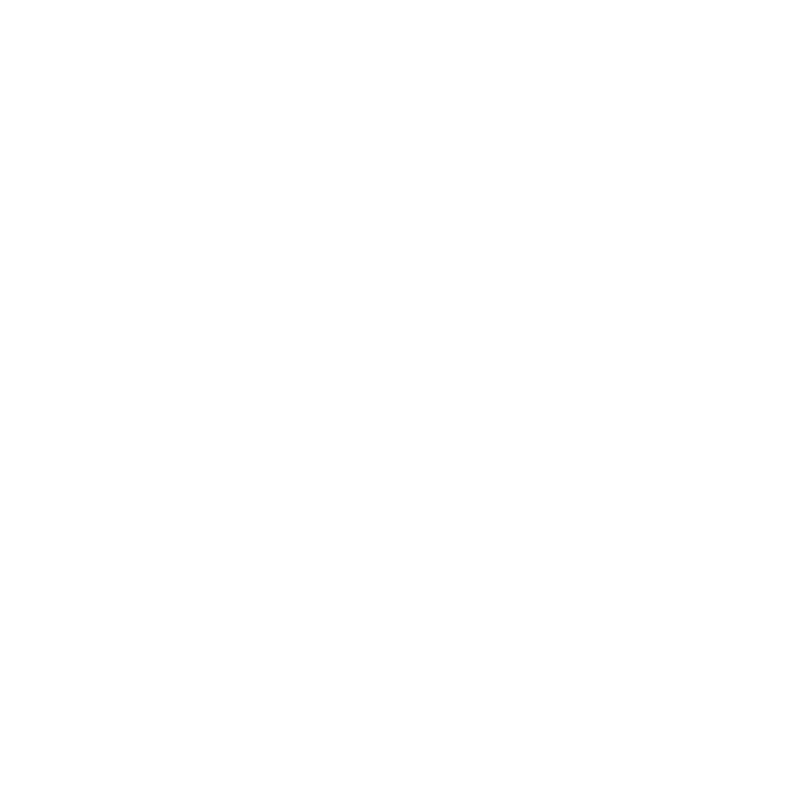

<IPython.core.display.Javascript object>


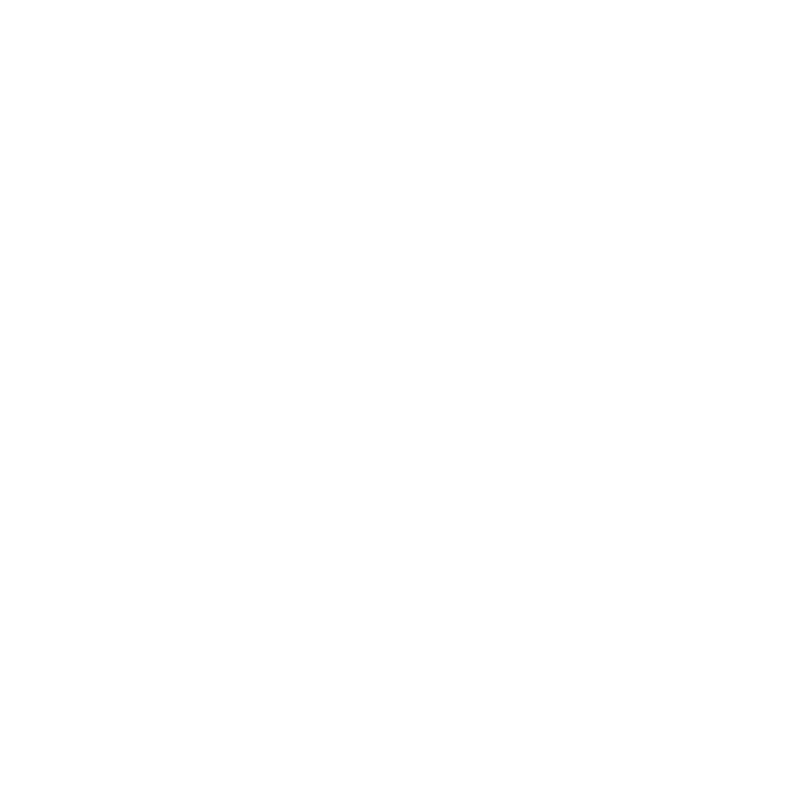

<IPython.core.display.Javascript object>


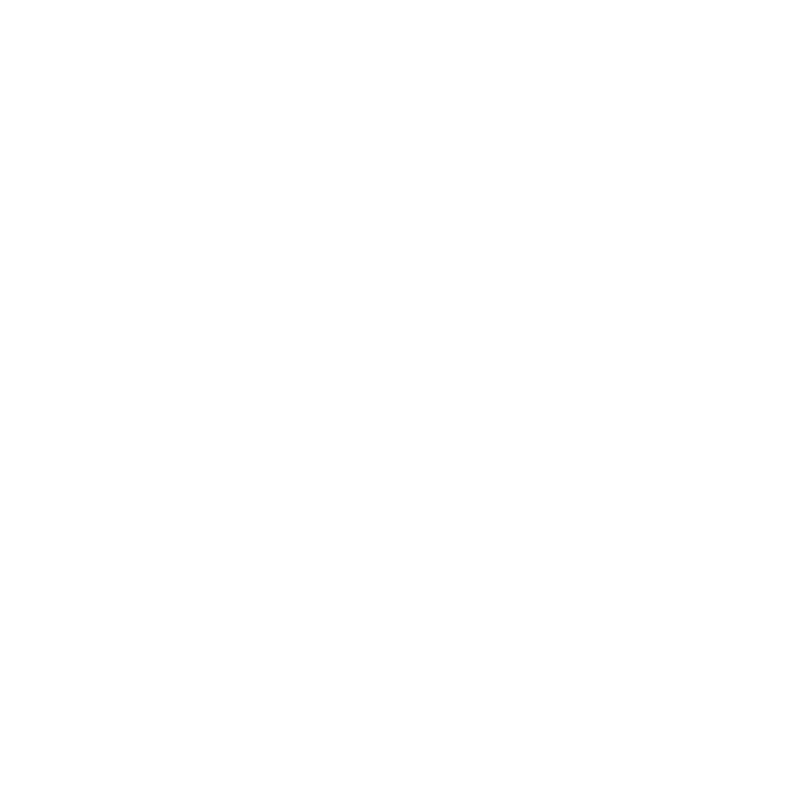

<IPython.core.display.Javascript object>


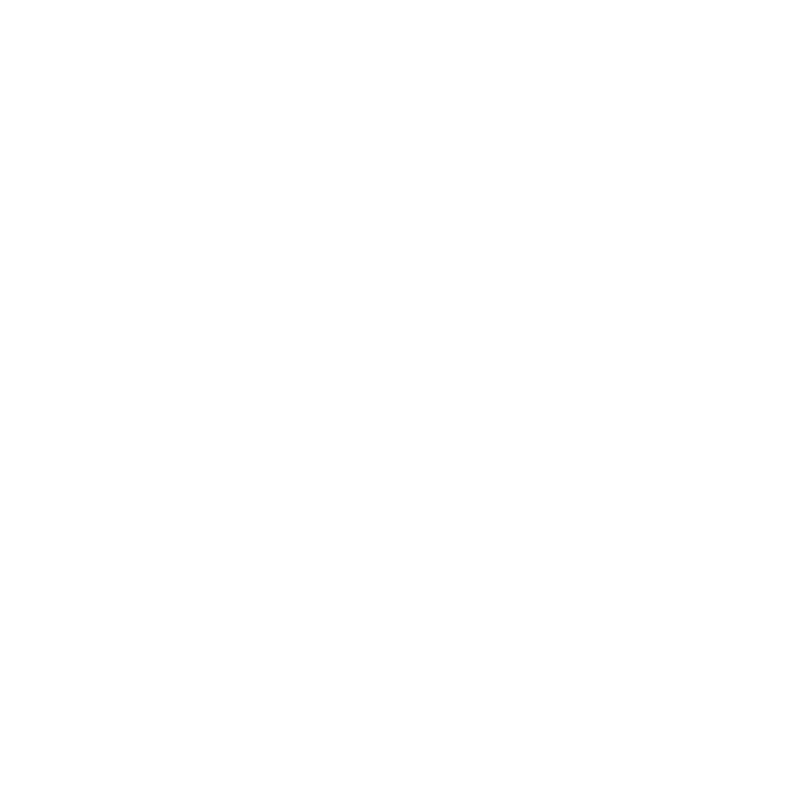

<IPython.core.display.Javascript object>


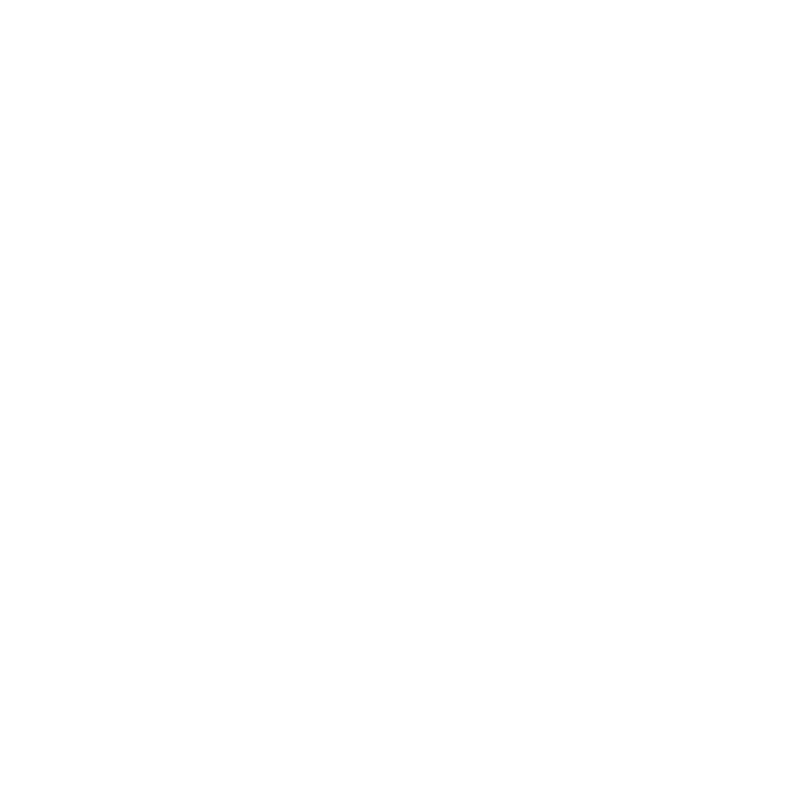

<IPython.core.display.Javascript object>


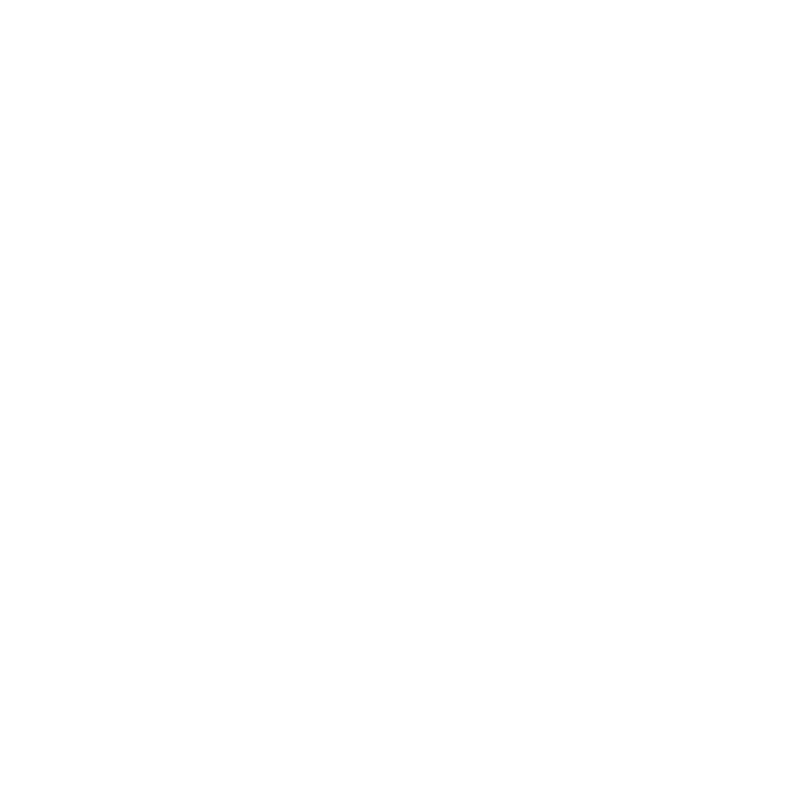

<IPython.core.display.Javascript object>


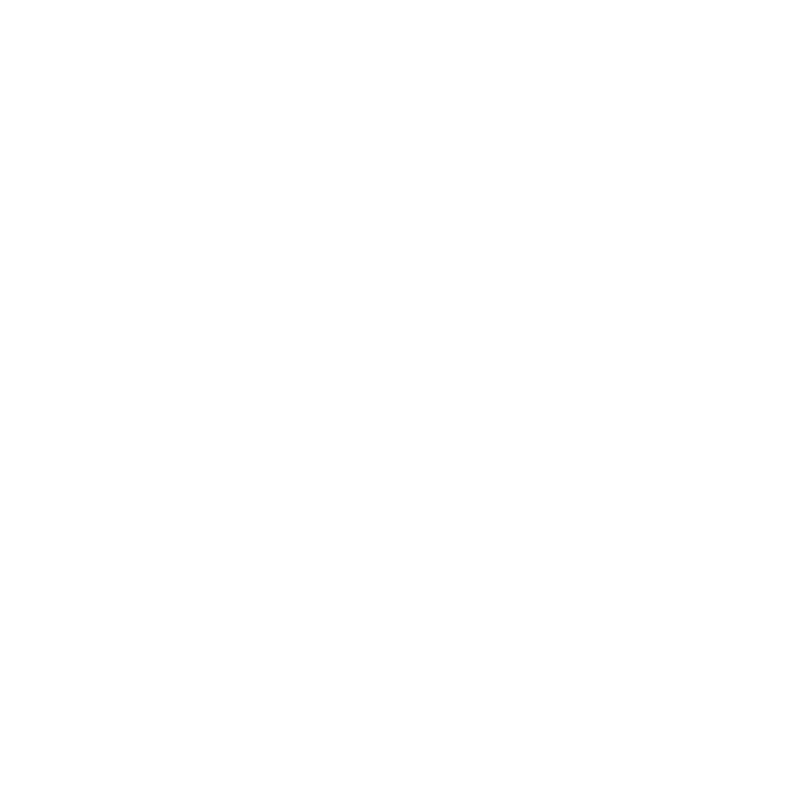

<IPython.core.display.Javascript object>


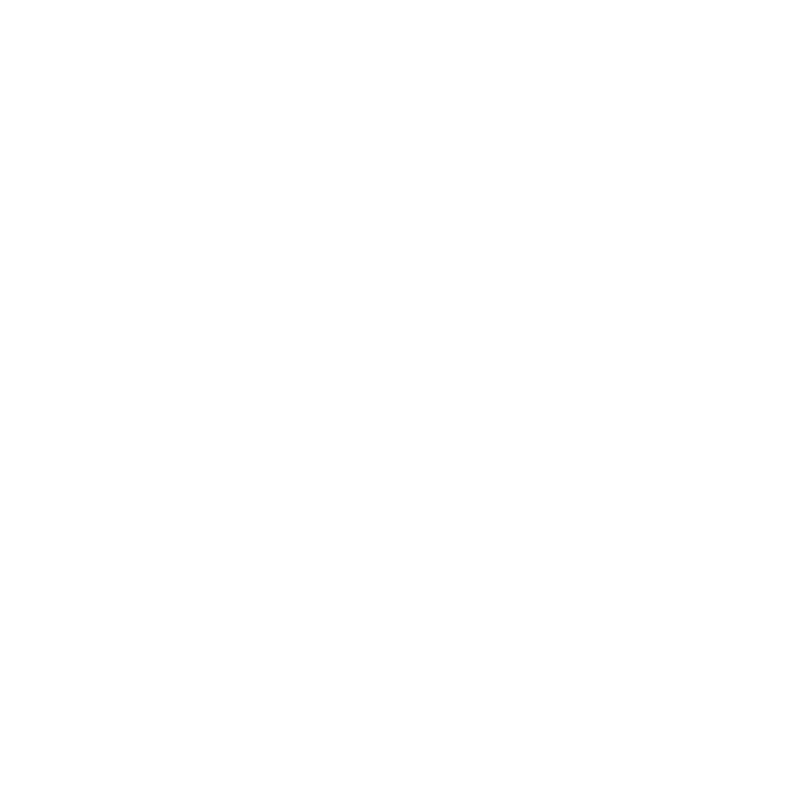

In [195]:
#subcat = 'adult'
for subcat in df_censorship.subcat.unique():
    df4 = df_filtered[df_filtered['subcat']==subcat].set_index('country')[['case1','case3']]
    if subcat == 'kids_and_teen':
        subcat = 'kids'
    model = 'scatter'
    fig2, ax2 = plt.subplots(1,1, figsize=(10,10))
    ax2.scatter(df4['case1'], df4['case3'])
    for label, x, y in zip(df4.index, df4['case1'], df4['case3']):
        ax2.annotate(
            label, 
            xy = (x, y), xytext = (-20, 20),
            textcoords = 'offset points', ha = 'right', va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
    ax2.set_title(model + ' ' + subcat + ' case: 1,3')
    ax2.grid(1)
    fig2.savefig(RESULTS + "subcat/" + model + '-' + subcat)
    plt.close()

<IPython.core.display.Javascript object>


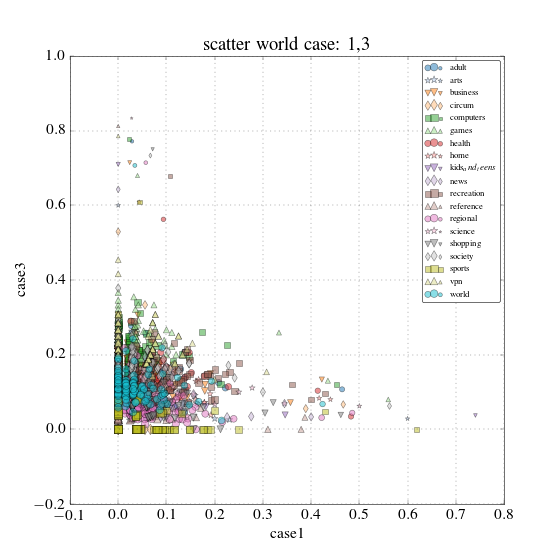

In [196]:
from itertools import cycle
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.  
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)  
    
col=cycle(tableau20)
mark=cycle(['o','*','v','d','s','^'])

fig2, ax2 = plt.subplots(1,1, figsize=(7,7))

#subcat = 'adult'
for subcat in df_censorship.subcat.unique():
    df4 = df_filtered[df_filtered['subcat']==subcat].set_index('country')[['case1','case3', 'case2']]
    if subcat == 'kids_and_teen':
        subcat = 'kids'
    model = 'scatter'
    
    ax2.scatter(df4['case1'], df4['case3'], c=col.next(), marker=mark.next(),
                s=df4['case2']*50, label=subcat, alpha=0.5, edgecolor=None)
    #for label, x, y in zip(df4.index, df4['case1'], df4['case3']):
    #    ax2.annotate(
    #        label, 
    #        xy = (x, y), xytext = (-20, 20),
    #        textcoords = 'offset points', ha = 'right', va = 'bottom',
    #        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
    #        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
ax2.set_title(model + ' ' + subcat + ' case: 1,3')
ax2.set_ylabel('case3')
ax2.set_xlabel('case1')
#ax2.set_xscale('log')
#ax2.set_yscale('log')
ax2.grid(1)
ax2.legend(loc='best')
fig2.savefig(RESULTS + model + '-global-density-by-subcat')

In [227]:
df_filtered['case1/case13'] = df_filtered['case1']/(df_filtered['case3']+df_filtered['case1'])
df_filtered

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


case,subcat,country,case1,case2,case3,case1/case13
0,adult,AE,0.100000,0.800000,0.100000,0.500000
1,adult,AF,0.111111,0.777778,0.111111,0.500000
2,adult,AL,0.222222,0.666667,0.111111,0.666667
3,adult,AM,0.034483,0.862069,0.103448,0.250000
4,adult,AO,0.027778,0.833333,0.138889,0.166667
5,adult,AR,0.000000,0.914286,0.085714,0.000000
6,adult,AT,0.032258,0.806452,0.161290,0.166667
7,adult,AU,0.137931,0.724138,0.137931,0.500000
8,adult,AZ,0.027778,0.888889,0.083333,0.250000
9,adult,BA,0.000000,0.885714,0.114286,0.000000


In [ ]:
from itertools import cycle
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.  
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)  
    
col=cycle(tableau20)
mark=cycle(['o','*','v','d','s','^'])

fig2, ax2 = plt.subplots(1,1, figsize=(7,7))

#subcat = 'adult'
for subcat in df_censorship.subcat.unique():
    df4 = df_filtered[df_filtered['subcat']==subcat].set_index('country')[['case2','case1/case13']]
    if subcat == 'kids_and_teen':
        subcat = 'kids'
    model = 'scatter'
    
    ax2.scatter(df4['case2'], df4['case1/case13'], c=col.next(), marker=mark.next(),
                s=df4['case2']*50, label=subcat, alpha=0.5, edgecolor=None)
    #for label, x, y in zip(df4.index, df4['case1'], df4['case3']):
    #    ax2.annotate(
    #        label, 
    #        xy = (x, y), xytext = (-20, 20),
    #        textcoords = 'offset points', ha = 'right', va = 'bottom',
    #        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
    #        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
ax2.set_title(model + ' ' + subcat + ' case: 2 vs 1/1+3')
ax2.set_ylabel('server-to-client/total-tcp-ip-censorship')
ax2.set_xlabel('no-blocking')
#ax2.set_xscale('log')
#ax2.set_yscale('log')
ax2.grid(1)
ax2.legend(loc='best')
fig2.savefig(RESULTS + model + '-global-density-by-subcat-ratios')

In [ ]:
from itertools import cycle
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.  
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)  
    
col=cycle(tableau20)
mark=cycle(['o','*','v','d','s','^'])

fig2, ax2 = plt.subplots(1,1, figsize=(7,7))

#subcat = 'adult'
for subcat in df_censorship.subcat.unique():
    df4 = df_filtered[df_filtered['subcat']==subcat].set_index('country')[['case1','case3', 'case2']]
    if subcat == 'kids_and_teen':
        subcat = 'kids'
    model = 'scatter'
    
    ax2.scatter(df4['case1'], df4['case3'], c=col.next(), marker=mark.next(),
                s=df4['case2']*50, label=subcat, alpha=0.5, edgecolor=None)
    #for label, x, y in zip(df4.index, df4['case1'], df4['case3']):
    #    ax2.annotate(
    #        label, 
    #        xy = (x, y), xytext = (-20, 20),
    #        textcoords = 'offset points', ha = 'right', va = 'bottom',
    #        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
    #        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
ax2.set_title(model + ' ' + subcat + ' case: 1,3')
ax2.set_ylabel('client-to-server-dropped')
ax2.set_xlabel('server-to-client-dropped')
#ax2.set_xscale('log')
#ax2.set_yscale('log')
ax2.grid(1)
ax2.legend(loc='best')
fig2.savefig(RESULTS + model + '-global-density-by-subcat')

## Case 1 and 3 on scatter plot for each subcat

# WORLD MAP

In [167]:
import numpy as np
#from world_map_maker import create_world_map

In [168]:
create_world_map(censorship_ratio['case1'], "Server to Client Blocking", True)

0.00863464651916 0.0651260504202
http://chart.apis.google.com/chart?cht=map:fixed=-60,-20,80,-35&chs=600x400&chma=0,60,0,0&chld=AA|AA|AA|AA|AA|AA|VPN|CIRCUM|REGIONAL|SCIENCE|COMPUTERS|HOME|SOCIETY|ARTS|REFERENCE|WORLD|GAMES|NEWS|BUSINESS|ADULT|KIDS_AND_TEENS|SPORTS|HEALTH|SHOPPING|RECREATION&chco=808080|808080|c6dbef|9ecae1|6baed6|3182bd|08519c|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|9ecae1|9ecae1|9ecae1|9ecae1|9ecae1|9ecae1|6baed6|6baed6|3182bd|3182bd|08519c|08519c&chdl=No+Data|0.9-2.0%|2.0-3.1%|3.1-4.3%|4.3-5.4%|5.4-6.5%&chdls=000000,14&chf=bg,s,EFF3FF&chtt=Server+to+Client+Blocking&chts=000000,20,c


In [169]:
create_world_map(censorship_ratio['case2'], "No Blocking", True)

0.663504464286 0.832755298651
http://chart.apis.google.com/chart?cht=map:fixed=-60,-20,80,-35&chs=600x400&chma=0,60,0,0&chld=AA|AA|AA|AA|AA|AA|GAMES|COMPUTERS|VPN|HEALTH|SOCIETY|NEWS|RECREATION|SHOPPING|SCIENCE|ADULT|HOME|REGIONAL|ARTS|WORLD|KIDS_AND_TEENS|CIRCUM|BUSINESS|REFERENCE|SPORTS&chco=808080|808080|c6dbef|9ecae1|6baed6|3182bd|08519c|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|c6dbef|9ecae1&chdl=No+Data|66.4-69.7%|69.7-73.1%|73.1-76.5%|76.5-79.9%|79.9-83.3%&chdls=000000,14&chf=bg,s,EFF3FF&chtt=No+Blocking&chts=000000,20,c


In [170]:
create_world_map(censorship_ratio['case3'], "Client to Server Blocking", True)

0.0136 0.211548839719
http://chart.apis.google.com/chart?cht=map:fixed=-60,-20,80,-35&chs=600x400&chma=0,60,0,0&chld=AA|AA|AA|AA|AA|AA|BUSINESS|SHOPPING|SPORTS|RECREATION|REFERENCE|KIDS_AND_TEENS|REGIONAL|HOME|NEWS|ARTS|WORLD|ADULT|CIRCUM|HEALTH|SCIENCE|SOCIETY|COMPUTERS|GAMES|VPN&chco=808080|808080|c6dbef|9ecae1|6baed6|3182bd|08519c|c6dbef|c6dbef|c6dbef|9ecae1|9ecae1|9ecae1|9ecae1|9ecae1|9ecae1|9ecae1|9ecae1|9ecae1|6baed6|6baed6|6baed6|08519c|08519c|08519c|08519c&chdl=No+Data|1.4-5.3%|5.3-9.3%|9.3-13.2%|13.2-17.2%|17.2-21.2%&chdls=000000,14&chf=bg,s,EFF3FF&chtt=Client+to+Server+Blocking&chts=000000,20,c


# COSINE SIMILARTY

In [235]:
from scipy.spatial.distance import cosine

#df_multidim = df_filtered.pivot(index='case', columns='subcat')
df_filtered.pivot()
#df_multidim.corr()

case,subcat,country,case1,case2,case3,case1/case13
0,adult,AE,0.100000,0.800000,0.100000,0.500000
1,adult,AF,0.111111,0.777778,0.111111,0.500000
2,adult,AL,0.222222,0.666667,0.111111,0.666667
3,adult,AM,0.034483,0.862069,0.103448,0.250000
4,adult,AO,0.027778,0.833333,0.138889,0.166667
5,adult,AR,0.000000,0.914286,0.085714,0.000000
6,adult,AT,0.032258,0.806452,0.161290,0.166667
7,adult,AU,0.137931,0.724138,0.137931,0.500000
8,adult,AZ,0.027778,0.888889,0.083333,0.250000
9,adult,BA,0.000000,0.885714,0.114286,0.000000
